In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import argparse
import pathlib
from tensorflow.keras import layers
import sys
import numpy as np
from sklearn.decomposition import IncrementalPCA
from scipy.stats import wasserstein_distance,energy_distance
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt

# Lista de Variables para Configuración Primer Epxilon

In [3]:
## Lista de Parametros
Arq = 'vgg16'
Cap = 'sequential'
Att = 'CW'
Epx = '0005'
Epx_val = 0.005
DS = 'fashion_mnist'

In [4]:
def FGSM_GEN(model, image_in, target_label, epsilon,tiles=10):

  with tf.GradientTape() as tape:
    tape.watch(image_in)
    image= tf.expand_dims(image_in, axis=0)
    image = tf.tile(image, (tiles, 1, 1, 1))
    prediction = model(image)
    loss = tf.math.reduce_mean(nll(target_label, prediction))

  gradient = tape.gradient(loss, image_in)
  perturbation = epsilon * tf.sign(gradient)
  adversary = image_in + perturbation
  adversary = tf.clip_by_value(adversary, 0, 1)

  return adversary

## Ataque PGD
def pgd_attack(model, image, target_label, epsilon=0.15, num_steps=100, step_size=0.01):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy(from_logits=True)(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

## Ataque C&W
def pgd_attack(model, image, target_label, num_steps=500, step_size=0.0, epsilon=0.01):
    def loss_(image,target_label):
        image = tf.expand_dims(image, axis=0)
        image_tile = tf.tile(image, (5, 1, 1, 1))
        logits = model(image_tile)
        targets = tf.reduce_sum(logits * target_label, axis=1)
        others = tf.reduce_max(logits * (1 - target_label), axis=1)
        return tf.maximum(0.0, others - targets + step_size)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = tf.math.reduce_mean(loss_(image,target_label))

        gradient = tape.gradient(loss, image)
        image = image - epsilon * tf.sign(gradient)
        image = tf.clip_by_value(image, 0., 255.)

    return image
'''def pgd_attack_soft(model, image, target_label, epsilon=0.15, num_steps=1000, step_size=0.001):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy()(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image'''
def get_layer_dictionary(model_pret,input_shape=(32,32,1)):
  dict_models={}
  input=xvar=tf.keras.Input(input_shape)
  for idx,layer in enumerate(model_pret.layers):
    xvar=layer(xvar)
    dict_models[layer.name]=tf.keras.Model(input,xvar,name=layer.name)
    print(idx,layer.name)
  return dict_models

In [5]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32

## Ejemplo solo con la clase 0 para los de test-train

In [6]:
from models.vgg_b1_Re import VGG as VGGb1r
from models.vgg_bt_Re import VGG as VGGbtr
vgg_b1r=VGGb1r(Arq,10)
vgg_btr=VGGbtr(Arq,10)

vgg_b1r.build((None,32,32,1))
vgg_b1r.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16b1Re/mnist/checkpoint')
vgg_btr.build((None,32,32,1))
vgg_btr.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16btRe/mnist/checkpoint')

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [7]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)
    kl = sum(vgg_b1r.losses)
    return nll + kl / len_train
vgg_b1r.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss=nll,
                metrics=["accuracy"])

In [8]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)
    kl = sum(vgg_btr.losses)
    return nll + kl / len_train
vgg_btr.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                loss=nll,
                metrics=["accuracy"])

# Verificar que los tres modelos estan correctamente cargados

# Victima 2

## Ataque 0

In [9]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 2
Vic_loc = 25
Cat = 0

In [10]:
BATCH_SIZE=128
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [11]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 4s 81ms/step - loss: 3072.4016 - accuracy: 0.0275


[3072.401611328125, 0.02747252769768238]

In [12]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 4s 72ms/step - loss: 120.6119 - accuracy: 0.0110


[120.61186981201172, 0.010989011265337467]

### vgg_b1R

In [13]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [14]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [15]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [16]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [17]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [18]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [19]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


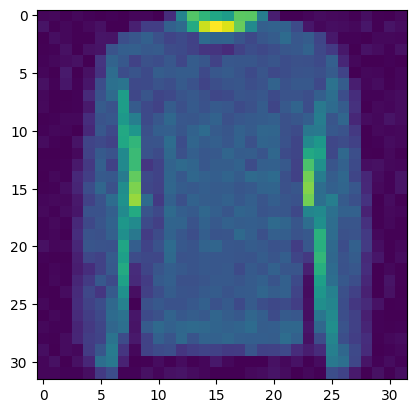

In [20]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [21]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [22]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [23]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [24]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1859001662981385
distancia energia distribucion base y el ejemplo natural  1.1563092661858803


In [25]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [26]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.8493983804991003
distancia energia distribucion base y el ejemplo adversario  0.9987098619550254


In [27]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-28-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-28-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

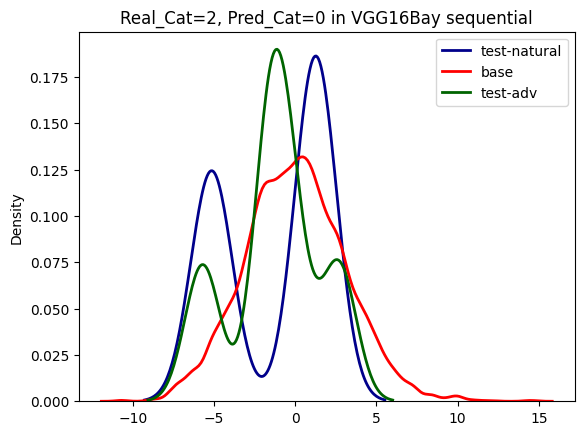

In [28]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [29]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [30]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [31]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [32]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [33]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [34]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [35]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


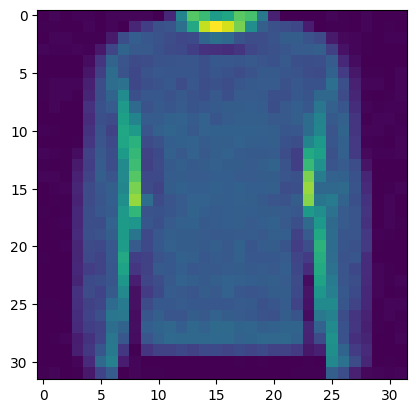

In [36]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [37]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [38]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [39]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [40]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.4403823427611915
distancia energia distribucion base y el ejemplo natural  1.5235072707153001


In [41]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [42]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.773273070642862
distancia energia distribucion base y el ejemplo adversario  1.6465758850746808


In [43]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-44-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-44-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

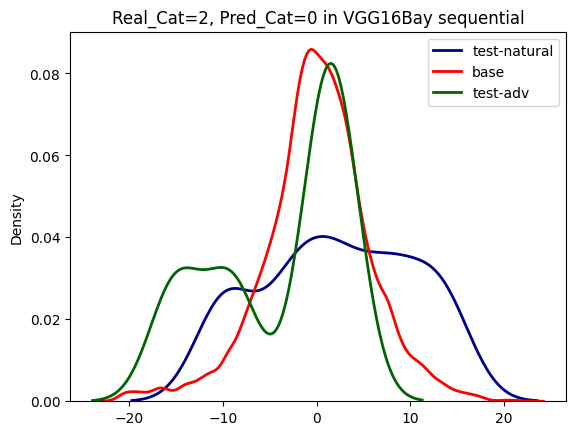

In [44]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [45]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [46]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [47]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 65ms/step - loss: 3069.6936 - accuracy: 0.2401


[3069.693603515625, 0.2401352822780609]

In [48]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 63ms/step - loss: 111.9677 - accuracy: 0.8940


[111.96772003173828, 0.8940247893333435]

### vgg_b1R

In [49]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [50]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [51]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [52]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [53]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [54]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [55]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


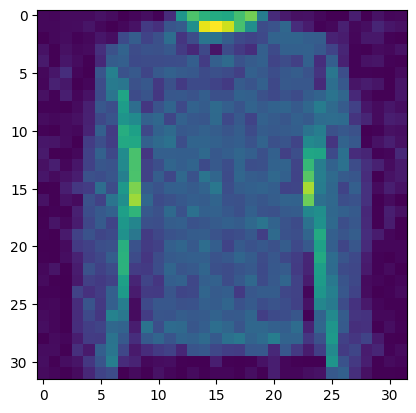

In [56]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [57]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [58]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [59]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [60]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5715409342241176
distancia energia distribucion base y el ejemplo natural  0.8960629820946245


In [61]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [62]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.0555257468865733
distancia energia distribucion base y el ejemplo adversario  1.1349423050766536


In [63]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-64-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-64-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

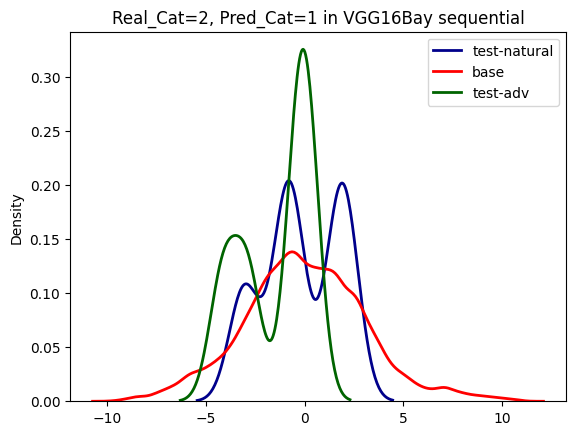

In [64]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [65]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [66]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [67]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [68]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [69]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [70]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [71]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


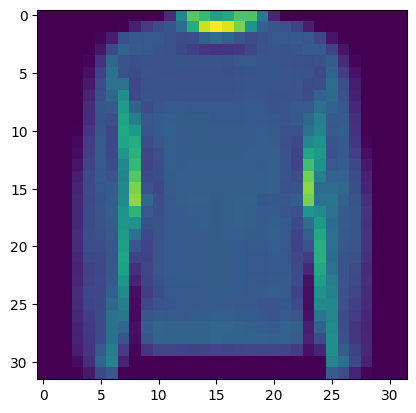

In [72]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [73]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [74]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [75]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [76]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.613380365065125
distancia energia distribucion base y el ejemplo natural  1.5714165522146413


In [77]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [78]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.015018966241811
distancia energia distribucion base y el ejemplo adversario  2.3568607918241042


In [79]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-80-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-80-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

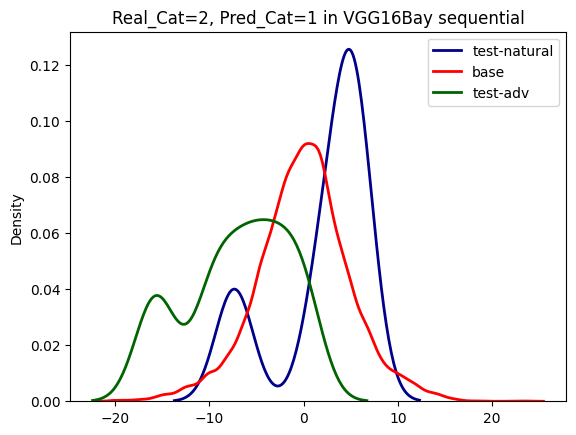

In [80]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [81]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [82]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [83]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 50ms/step - loss: 3070.2288 - accuracy: 0.1771


[3070.228759765625, 0.17706012725830078]

In [84]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 50ms/step - loss: 121.8672 - accuracy: 0.0278


[121.86719512939453, 0.027839643880724907]

### vgg_b1R

In [85]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [86]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [87]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [88]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [89]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [90]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [91]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


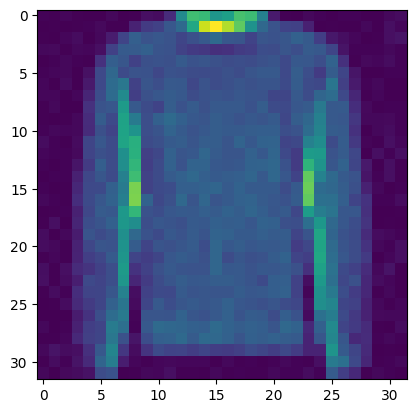

In [92]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [93]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [94]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [95]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [96]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.884690673722314
distancia energia distribucion base y el ejemplo natural  1.7141099115310445


In [97]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [98]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.0499680262391773
distancia energia distribucion base y el ejemplo adversario  1.7985546187420887


In [99]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-100-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-100-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

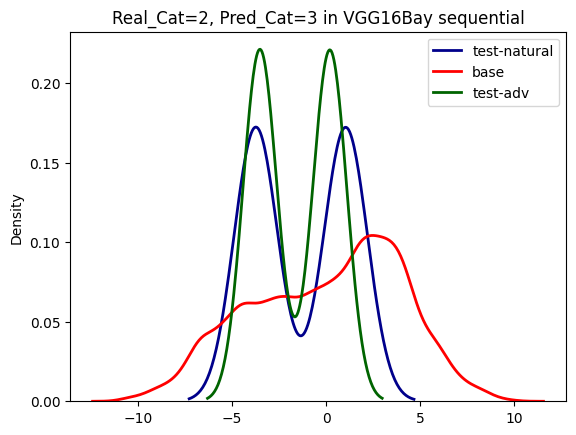

In [100]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [101]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [102]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [103]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [104]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [105]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [106]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [107]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


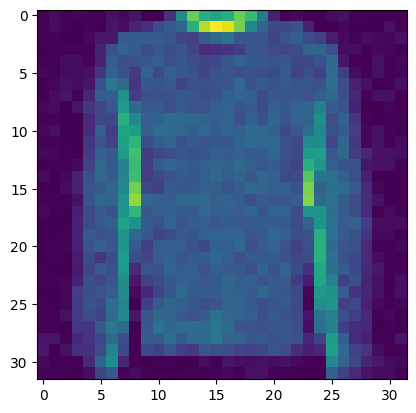

In [108]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [109]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [110]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [111]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [112]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.348337019650818
distancia energia distribucion base y el ejemplo natural  2.5197994646192425


In [113]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [114]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  15.030597782053157
distancia energia distribucion base y el ejemplo adversario  4.86455260498904


In [115]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-116-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-116-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

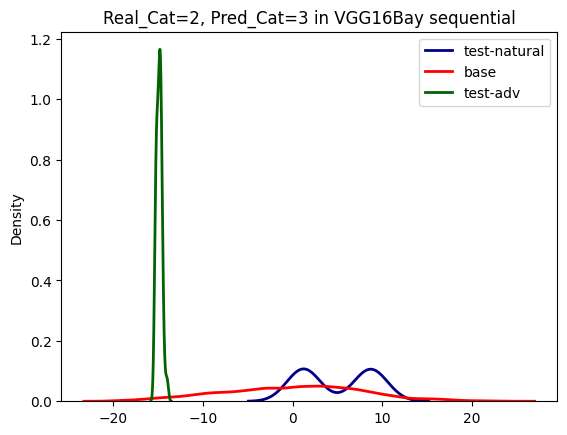

In [116]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [117]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [118]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [119]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 76ms/step - loss: 3071.6675 - accuracy: 0.0348


[3071.66748046875, 0.03475336357951164]

In [120]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 73ms/step - loss: 120.7033 - accuracy: 0.0112


[120.70332336425781, 0.011210761964321136]

### vgg_b1R

In [121]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [122]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [123]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [124]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [125]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [126]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [127]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


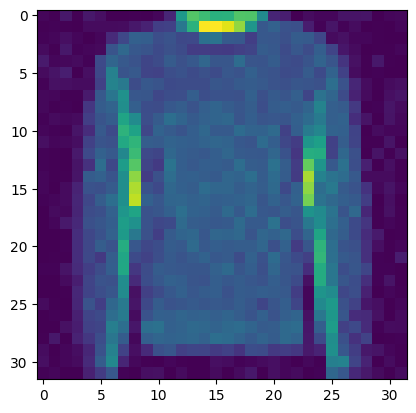

In [128]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [129]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [130]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [131]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [132]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.35436894576319
distancia energia distribucion base y el ejemplo natural  1.2207790680506618


In [133]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [134]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.7229354537137538
distancia energia distribucion base y el ejemplo adversario  0.9219197485843226


In [135]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-136-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-136-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

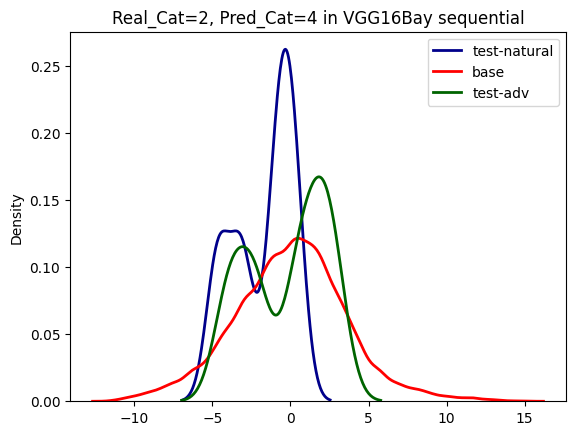

In [136]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [137]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [138]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [139]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [140]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [141]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [142]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [143]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


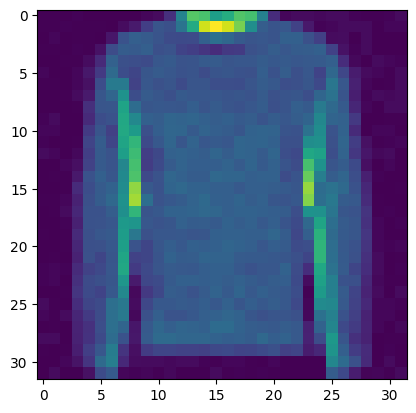

In [144]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [145]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [146]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [147]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [148]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.942227674433987
distancia energia distribucion base y el ejemplo natural  1.2562833593230225


In [149]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [150]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.090882880736994
distancia energia distribucion base y el ejemplo adversario  1.5444261822975758


In [151]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-152-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-152-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

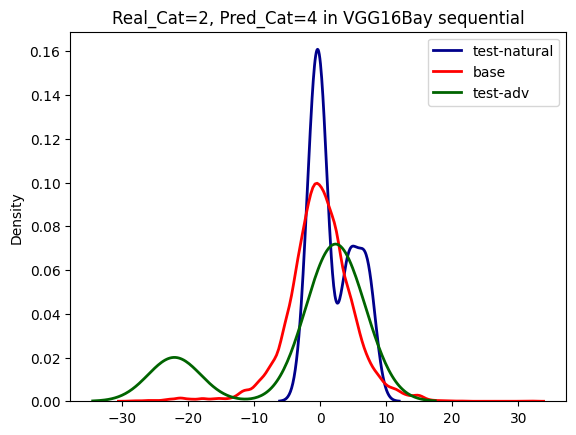

In [152]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [153]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [154]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [155]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 53ms/step - loss: 3072.5833 - accuracy: 0.0741


[3072.583251953125, 0.07411504536867142]

In [156]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 52ms/step - loss: 119.0725 - accuracy: 0.0896


[119.07247161865234, 0.08960177004337311]

### vgg_b1R

In [157]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [158]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [159]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [160]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [161]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [162]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [163]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


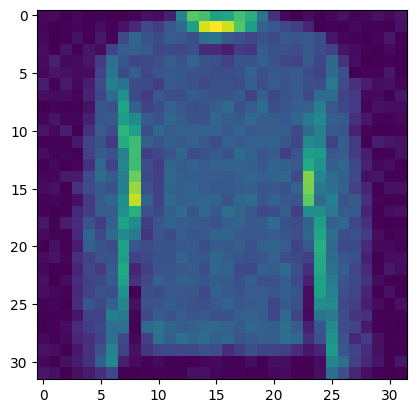

In [164]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [165]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [166]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [167]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [168]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  5.1258102877857725
distancia energia distribucion base y el ejemplo natural  2.3726507382378763


In [169]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [170]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.225440113322613
distancia energia distribucion base y el ejemplo adversario  2.2567912758321804


In [171]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-172-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-172-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

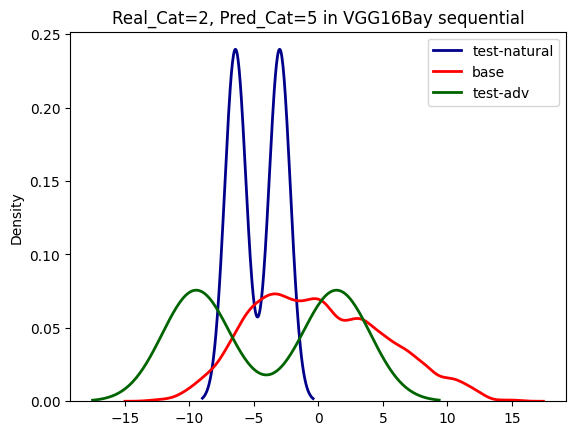

In [172]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [173]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [174]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [175]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [176]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [177]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [178]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [179]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


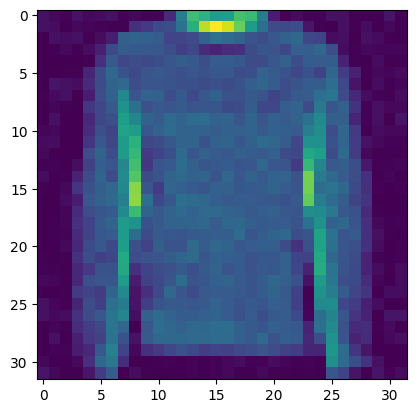

In [180]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [181]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [182]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [183]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [184]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.315376312538722
distancia energia distribucion base y el ejemplo natural  2.4441609179224364


In [185]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [186]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  11.485305273905098
distancia energia distribucion base y el ejemplo adversario  3.7633356244616416


In [187]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-188-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-188-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

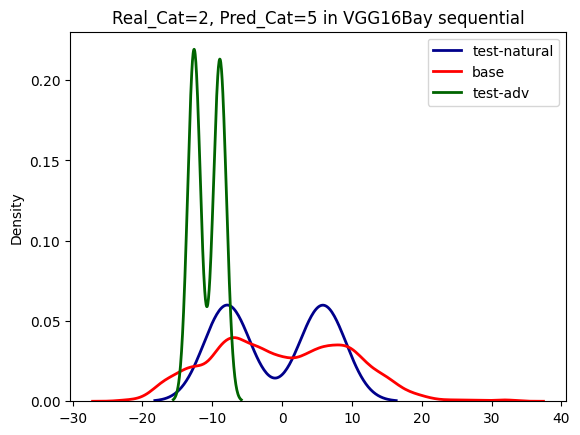

In [188]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [189]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [190]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [191]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 57ms/step - loss: 3070.3599 - accuracy: 0.1393


[3070.35986328125, 0.13929784297943115]

In [192]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 55ms/step - loss: 124.2754 - accuracy: 0.0011


[124.27544403076172, 0.0011325028026476502]

### vgg_b1R

In [193]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [194]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [195]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [196]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [197]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [198]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [199]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


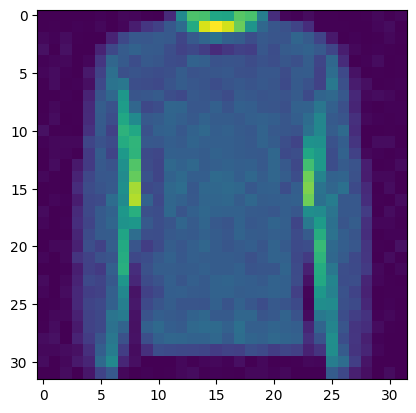

In [200]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [201]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [202]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [203]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [204]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.458887649107903
distancia energia distribucion base y el ejemplo natural  1.13288113334142


In [205]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [206]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.537145307590307
distancia energia distribucion base y el ejemplo adversario  1.2794702747310127


In [207]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-208-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-208-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

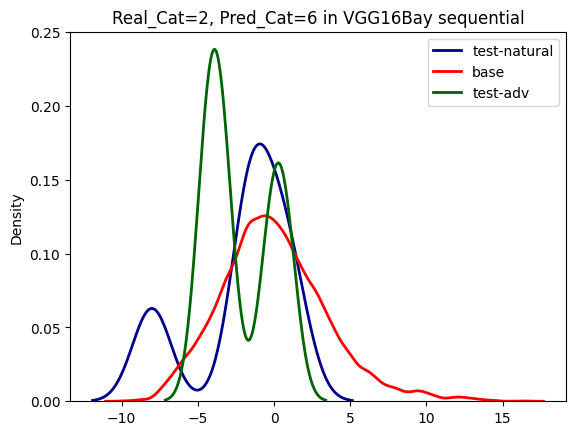

In [208]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [209]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [210]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [211]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [212]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [213]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [214]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [215]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


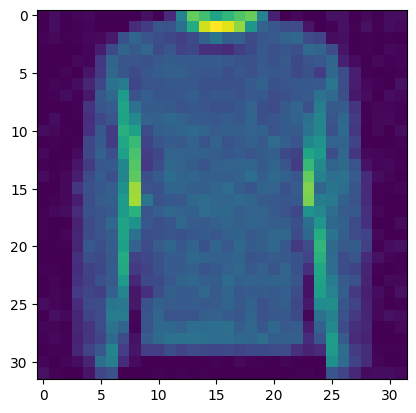

In [216]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [217]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [218]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [219]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [220]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.777737220621498
distancia energia distribucion base y el ejemplo natural  1.7289515075955157


In [221]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [222]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.241732286524208
distancia energia distribucion base y el ejemplo adversario  1.4723384555419832


In [223]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-224-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-224-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

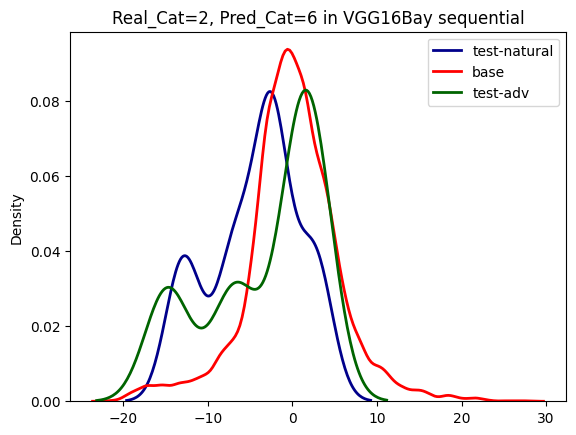

In [224]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [225]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [226]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [227]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 3073.8003 - accuracy: 0.0088


[3073.80029296875, 0.00876232236623764]

In [228]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 121.6794 - accuracy: 0.0175


[121.67938995361328, 0.01752464473247528]

### vgg_b1R

In [229]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [230]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [231]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [232]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [233]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [234]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [235]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  2


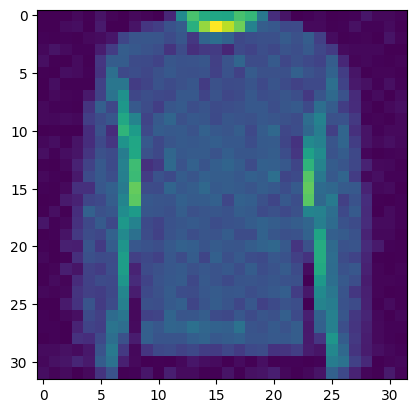

In [236]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [237]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[3]
[7]
[7]
[7]
[7]
[7]
[7]


In [238]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [239]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [240]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.435306950875821
distancia energia distribucion base y el ejemplo natural  1.7816851626592718


In [241]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [242]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.490323628157349
distancia energia distribucion base y el ejemplo adversario  2.379681311695474


In [243]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-244-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-244-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

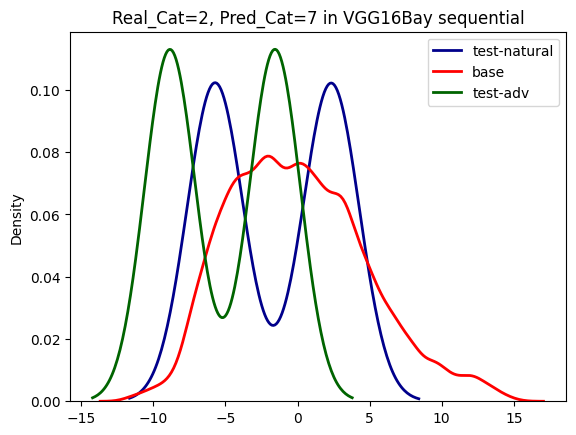

In [244]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [245]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [246]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [247]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [248]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [249]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [250]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [251]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  2


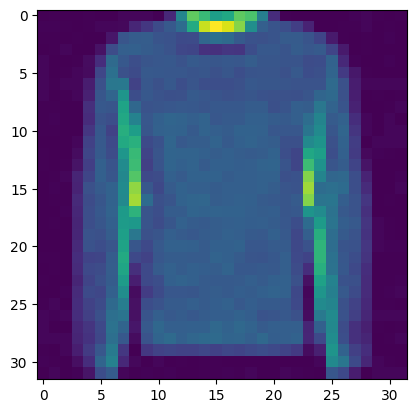

In [252]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [253]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [254]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [255]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [256]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  8.378267357557297
distancia energia distribucion base y el ejemplo natural  3.1980205480031745


In [257]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [258]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  16.530674461483127
distancia energia distribucion base y el ejemplo adversario  4.545692700937007


In [259]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-260-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-260-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

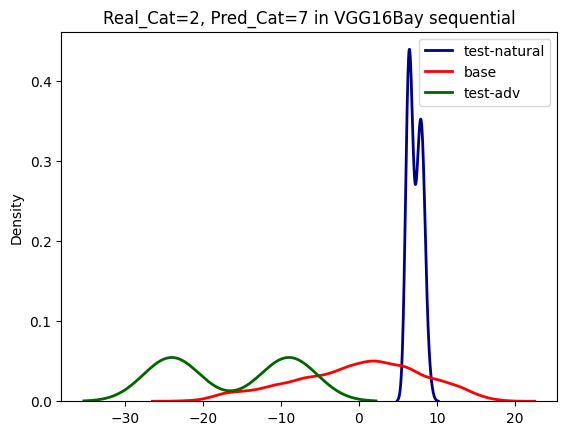

In [260]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [261]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [262]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [263]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 58ms/step - loss: 3071.6230 - accuracy: 0.0649


[3071.623046875, 0.06487695872783661]

In [264]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 58ms/step - loss: 115.6900 - accuracy: 0.2170


[115.6899642944336, 0.2170022428035736]

### vgg_b1R

In [265]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [266]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [267]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [268]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [269]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [270]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [271]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


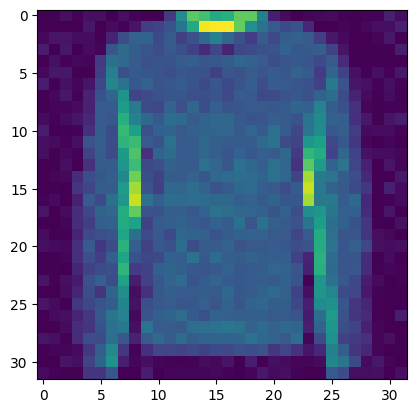

In [272]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [273]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [274]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [275]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [276]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.1270156792044985
distancia energia distribucion base y el ejemplo natural  1.4177602504972062


In [277]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [278]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.2319866002194315
distancia energia distribucion base y el ejemplo adversario  1.4860218580256537


In [279]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-280-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-280-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

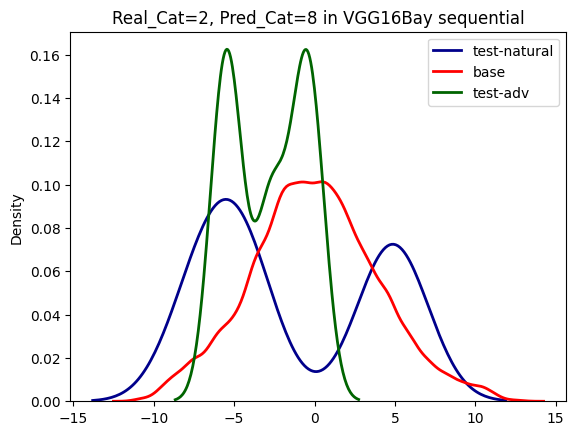

In [280]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [281]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [282]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [283]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [284]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [285]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [286]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [287]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


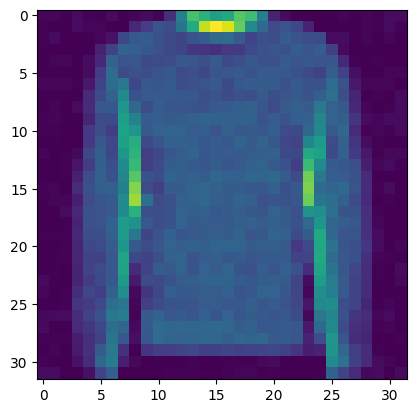

In [288]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [289]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [290]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [291]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [292]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.805640678598162
distancia energia distribucion base y el ejemplo natural  1.8464631812445587


In [293]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [294]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.549010967831838
distancia energia distribucion base y el ejemplo adversario  1.4610097226644696


In [295]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-296-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-296-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

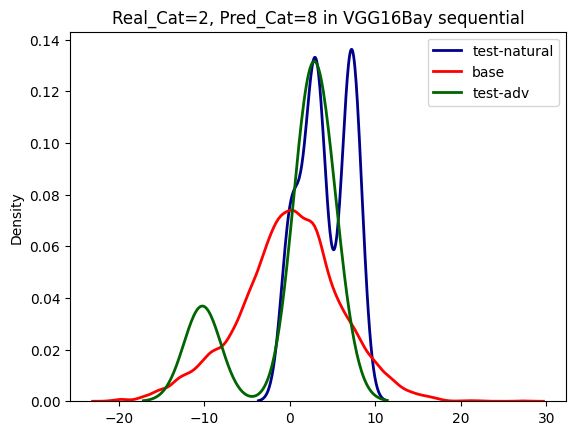

In [296]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [297]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [298]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [299]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 50ms/step - loss: 3077.0847 - accuracy: 0.0000e+00


[3077.084716796875, 0.0]

In [300]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 50ms/step - loss: 123.8138 - accuracy: 0.0000e+00


[123.81383514404297, 0.0]

### vgg_b1R

In [301]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [302]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [303]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [304]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [305]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [306]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [307]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


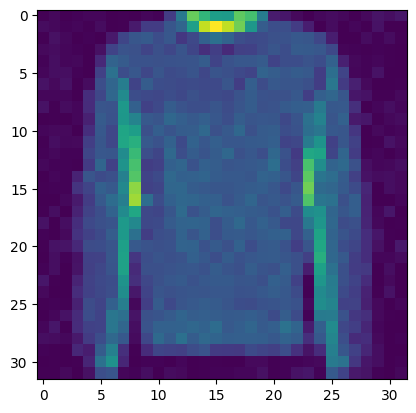

In [308]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [309]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [310]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [311]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [312]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1320795278400007
distancia energia distribucion base y el ejemplo natural  1.017867759460169


In [313]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [314]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.696518238474186
distancia energia distribucion base y el ejemplo adversario  1.9025524143583485


In [315]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-316-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-316-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

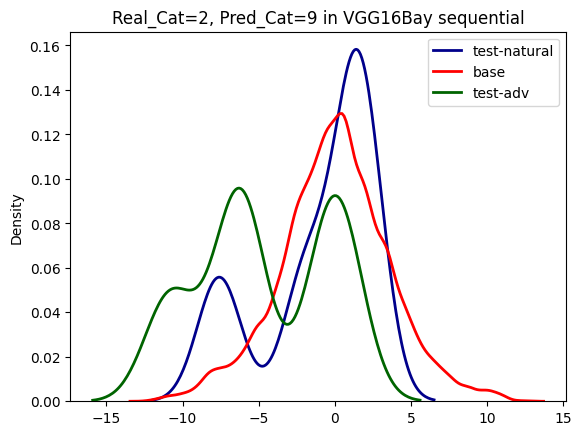

In [316]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [317]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [318]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [319]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [320]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [321]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [322]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [323]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


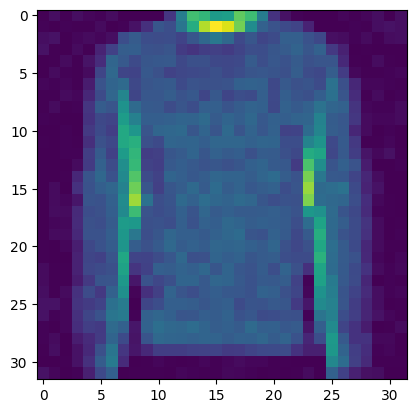

In [324]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [325]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [326]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [327]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [328]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.155708756677022
distancia energia distribucion base y el ejemplo natural  1.2348162835248142


In [329]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [330]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.176367644559258
distancia energia distribucion base y el ejemplo adversario  2.6991286486701154


In [331]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-332-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-332-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

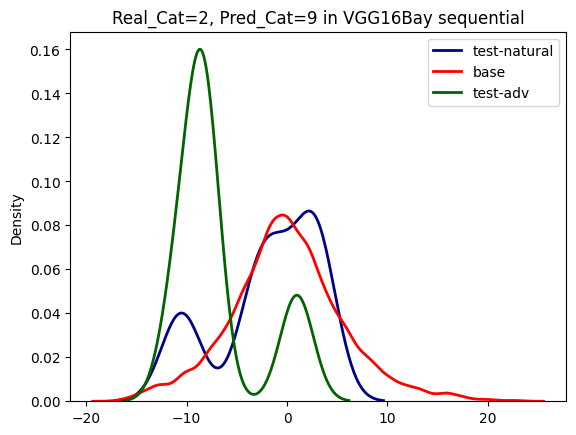

In [332]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 3

## Ataque 0

In [10]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 3
Vic_loc = 36
Cat = 0

In [11]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [12]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 4s 86ms/step - loss: 3072.2202 - accuracy: 0.0198


[3072.22021484375, 0.019780220463871956]

In [13]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 4s 75ms/step - loss: 120.5722 - accuracy: 0.0088


[120.5721664428711, 0.008791209198534489]

### vgg_b1R

In [14]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [15]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [16]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [17]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [18]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [19]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [20]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


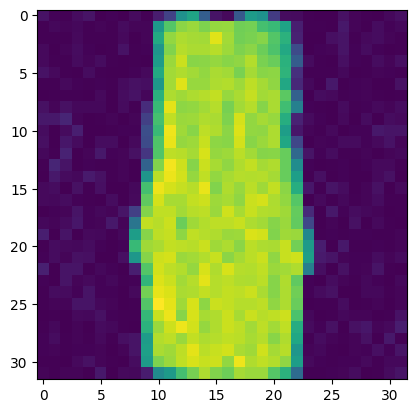

In [21]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [22]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [23]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [24]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [25]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1628996018739435
distancia energia distribucion base y el ejemplo natural  1.1465355283949041


In [26]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [27]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.0766712768558193
distancia energia distribucion base y el ejemplo adversario  1.0739113843827743


In [28]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-29-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-29-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

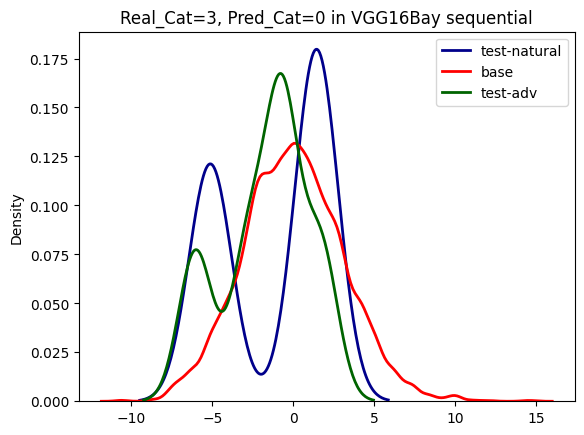

In [29]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [30]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [31]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [32]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [33]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [34]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [35]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [36]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


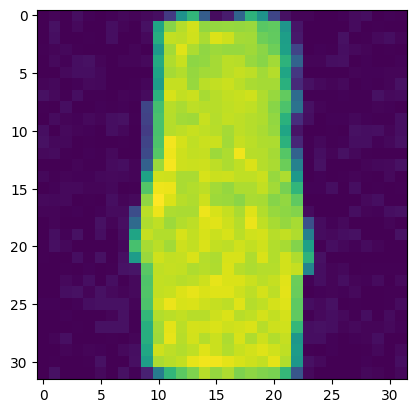

In [37]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [38]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [39]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [40]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [41]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.416716069163933
distancia energia distribucion base y el ejemplo natural  1.5124182825622958


In [42]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [43]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.955432108591151
distancia energia distribucion base y el ejemplo adversario  1.2617149758758512


In [44]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-45-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-45-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

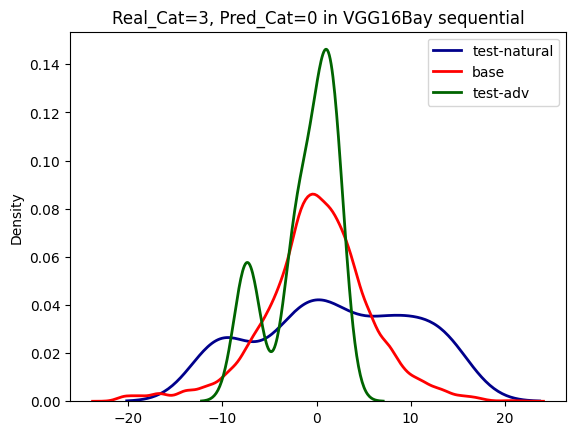

In [45]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [46]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [47]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [48]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 58ms/step - loss: 3069.8630 - accuracy: 0.2356


[3069.863037109375, 0.23562569916248322]

In [49]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 59ms/step - loss: 111.9898 - accuracy: 0.8850


[111.98983764648438, 0.8850056529045105]

### vgg_b1R

In [50]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [51]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [52]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [53]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [54]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [55]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [56]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


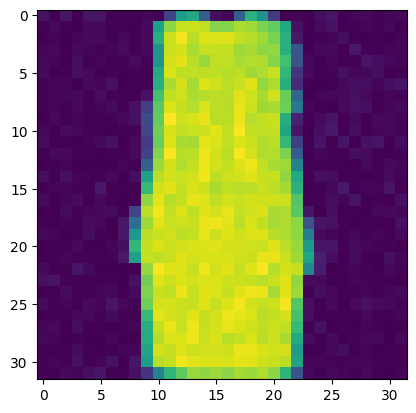

In [57]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [58]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[3]
[1]
[1]
[1]


In [59]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [60]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [61]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.561552091766461
distancia energia distribucion base y el ejemplo natural  0.8907513306990287


In [62]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [63]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.6147228261605215
distancia energia distribucion base y el ejemplo adversario  0.8816676079287522


In [64]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-65-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-65-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

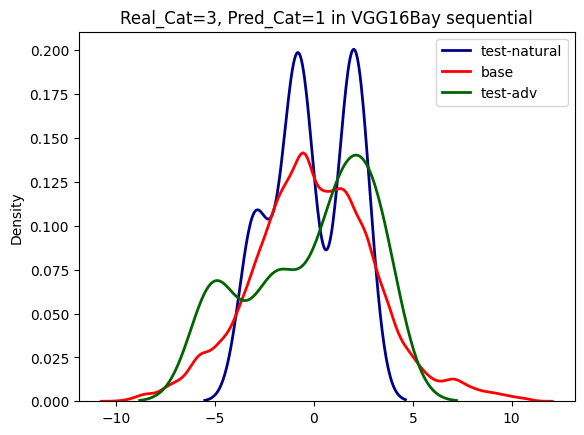

In [65]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [66]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [67]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [68]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [69]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [70]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [71]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [72]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


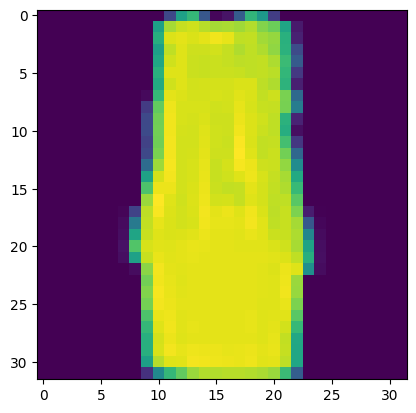

In [73]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [74]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [75]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [76]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [77]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.1085491847200273
distancia energia distribucion base y el ejemplo natural  1.32372979192415


In [78]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [79]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.4052108928073057
distancia energia distribucion base y el ejemplo adversario  1.0821573885849303


In [80]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-81-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-81-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

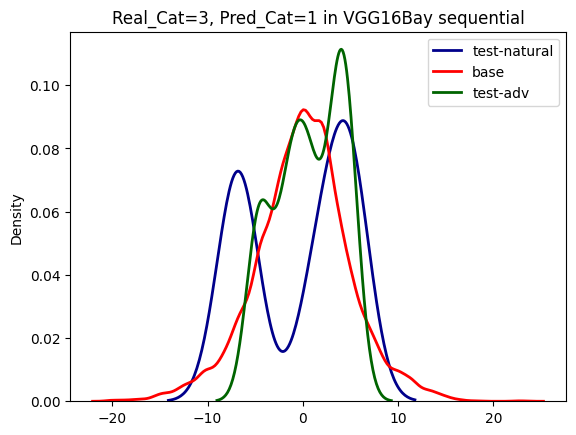

In [81]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [82]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [83]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [84]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 3068.8594 - accuracy: 0.5808


[3068.859375, 0.5807860493659973]

In [85]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 49ms/step - loss: 119.7014 - accuracy: 0.0098


[119.70137786865234, 0.009825327433645725]

### vgg_b1R

In [86]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [87]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [88]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [89]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [90]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [91]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [92]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


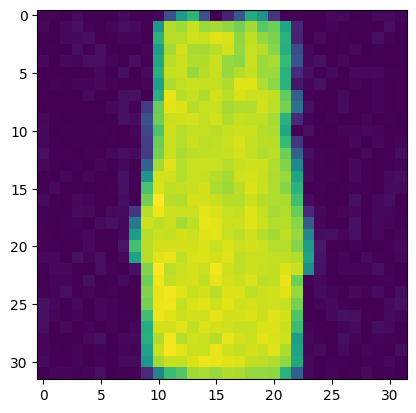

In [93]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [94]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [95]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [96]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [97]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.075067411888153
distancia energia distribucion base y el ejemplo natural  0.9891847137839948


In [98]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [99]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.9903713267735887
distancia energia distribucion base y el ejemplo adversario  1.00036736568103


In [100]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-101-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-101-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

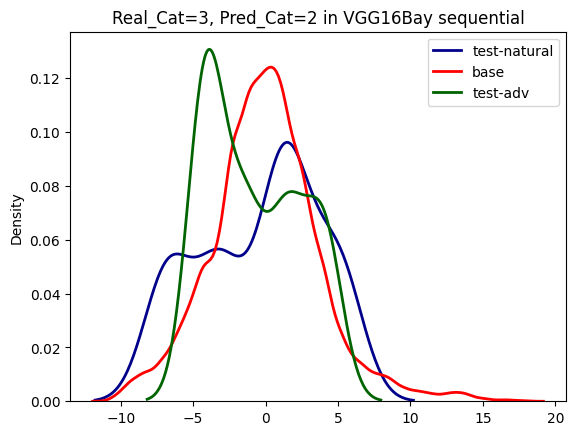

In [101]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [102]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [103]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [104]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [105]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [106]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [107]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [108]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


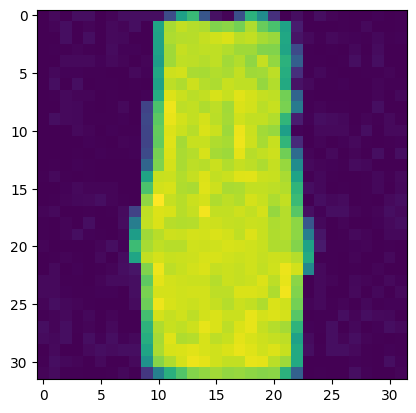

In [109]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [110]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [111]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [112]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [113]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.9627354888438147
distancia energia distribucion base y el ejemplo natural  1.244970543304226


In [114]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [115]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9633262664704
distancia energia distribucion base y el ejemplo adversario  1.226334076827182


In [116]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-117-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-117-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

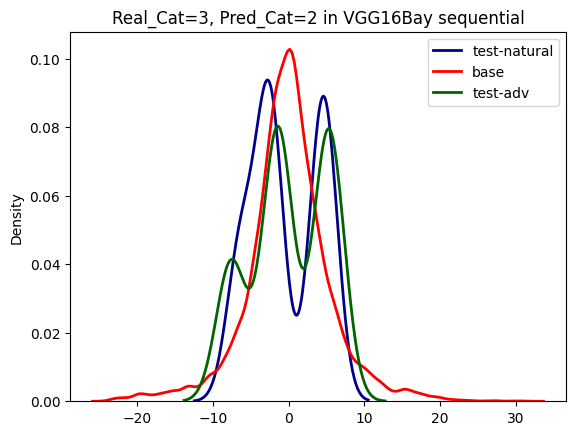

In [117]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [118]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [119]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [120]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 59ms/step - loss: 3072.9714 - accuracy: 0.0090


[3072.971435546875, 0.008968610316514969]

In [121]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 54ms/step - loss: 120.7337 - accuracy: 0.0112


[120.7336654663086, 0.011210761964321136]

### vgg_b1R

In [122]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [123]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [124]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [125]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [126]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [127]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [128]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  3


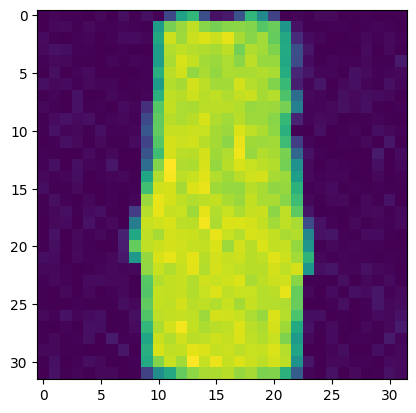

In [129]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [130]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [131]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [132]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [133]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.261480648442524
distancia energia distribucion base y el ejemplo natural  1.1723869180236524


In [134]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [135]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.3412227245446315
distancia energia distribucion base y el ejemplo adversario  1.1624548623456419


In [136]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-137-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-137-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

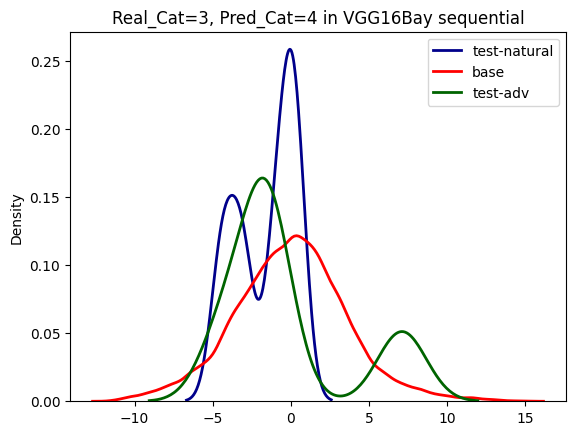

In [137]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [138]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [139]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [140]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [141]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [142]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [143]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [144]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  3


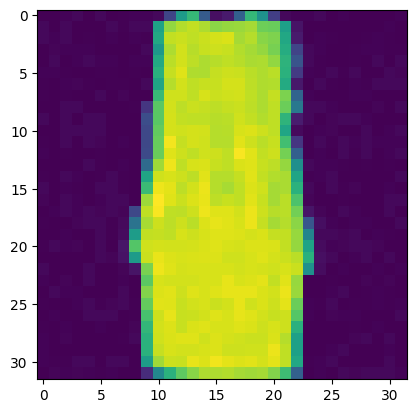

In [145]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [146]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [147]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [148]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [149]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.958674797669093
distancia energia distribucion base y el ejemplo natural  1.2586966348961426


In [150]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [151]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.473919320718033
distancia energia distribucion base y el ejemplo adversario  1.9112665005649292


In [152]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-153-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-153-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

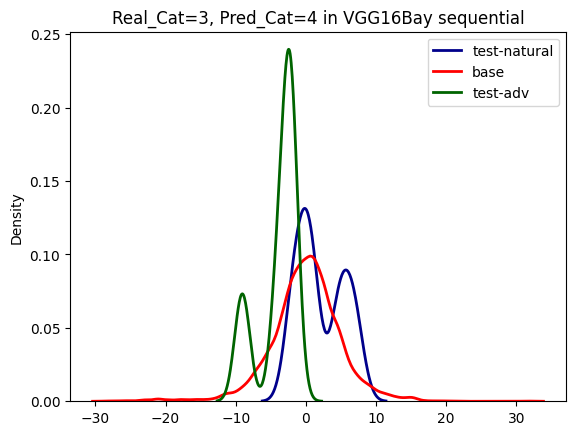

In [153]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [154]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [155]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [156]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 49ms/step - loss: 3073.6604 - accuracy: 0.0365


[3073.660400390625, 0.03650442510843277]

In [157]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 48ms/step - loss: 119.0281 - accuracy: 0.0885


[119.0280990600586, 0.08849557489156723]

### vgg_b1R

In [158]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [159]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [160]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [161]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [162]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [163]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [164]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  3


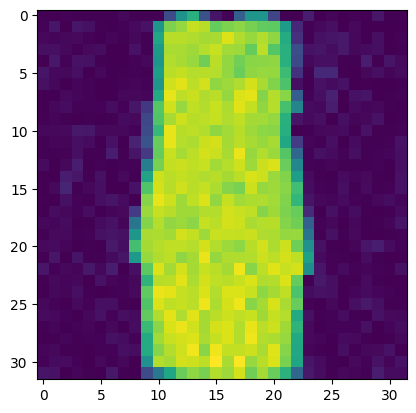

In [165]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [166]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [167]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [168]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [169]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.8853492835225945
distancia energia distribucion base y el ejemplo natural  2.291056479736062


In [170]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [171]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.288031113857142
distancia energia distribucion base y el ejemplo adversario  2.034634161877603


In [172]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-173-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-173-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

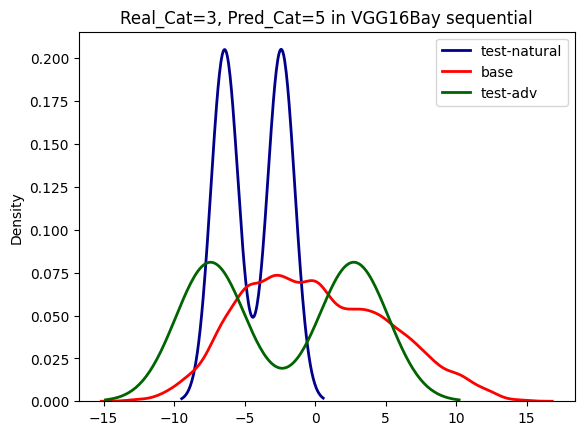

In [173]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [174]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [175]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [176]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [177]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [178]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [179]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [180]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  3


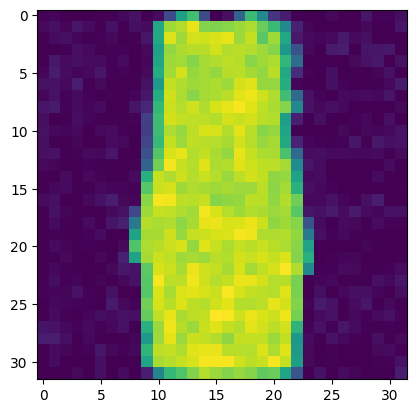

In [181]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [182]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [183]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [184]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [185]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.315490655278536
distancia energia distribucion base y el ejemplo natural  2.441689025311448


In [186]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [187]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.340066812760679
distancia energia distribucion base y el ejemplo adversario  2.669816153650655


In [188]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-189-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-189-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

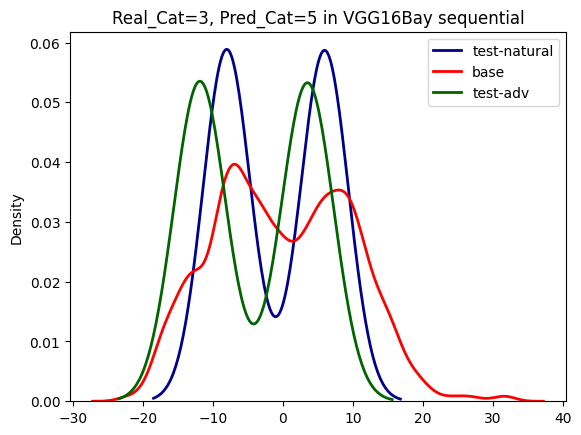

In [189]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [190]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [191]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [192]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 55ms/step - loss: 3070.5437 - accuracy: 0.1189


[3070.543701171875, 0.11891279369592667]

In [193]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 124.2049 - accuracy: 0.0011


[124.20487976074219, 0.0011325028026476502]

### vgg_b1R

In [194]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [195]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [196]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [197]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [198]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [199]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [200]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  3


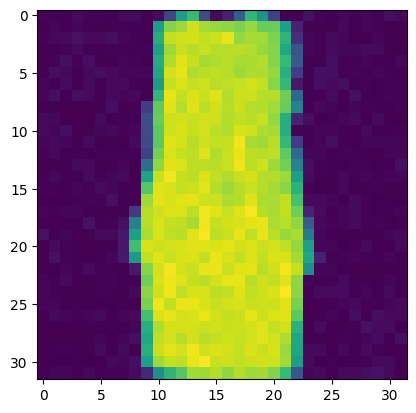

In [201]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [202]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [203]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [204]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [205]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.429524394518444
distancia energia distribucion base y el ejemplo natural  1.1161852280631774


In [206]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [207]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.6779222914392953
distancia energia distribucion base y el ejemplo adversario  0.9022969743624168


In [208]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-209-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-209-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

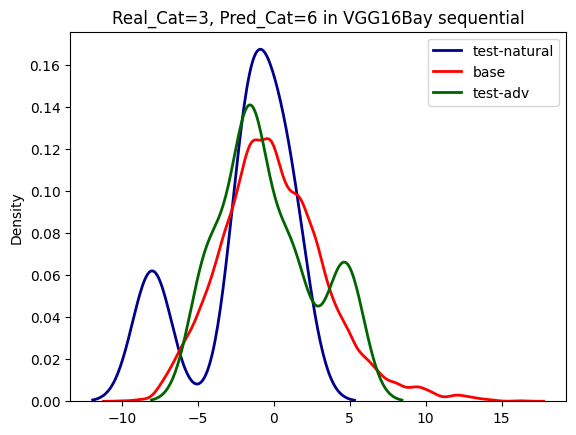

In [209]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [210]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [211]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [212]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [213]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [214]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [215]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [216]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  3


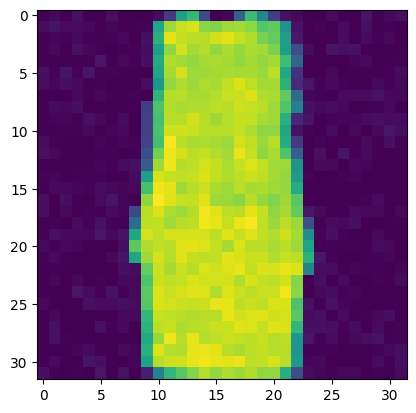

In [217]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [218]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [219]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [220]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [221]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.086364270450631
distancia energia distribucion base y el ejemplo natural  1.482151106957259


In [222]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [223]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.482054326878029
distancia energia distribucion base y el ejemplo adversario  1.5143234397174086


In [224]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-225-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-225-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

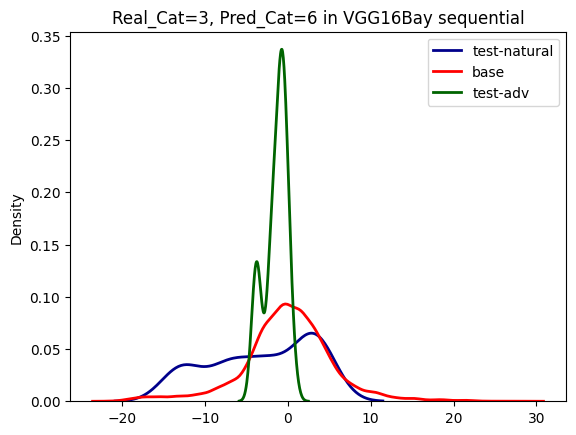

In [225]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [226]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [227]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [228]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 52ms/step - loss: 3072.5989 - accuracy: 0.0142


[3072.598876953125, 0.014238772913813591]

In [229]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 48ms/step - loss: 121.8456 - accuracy: 0.0164


[121.84557342529297, 0.016429353505373]

### vgg_b1R

In [230]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [231]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [232]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [233]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [234]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [235]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [236]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  3


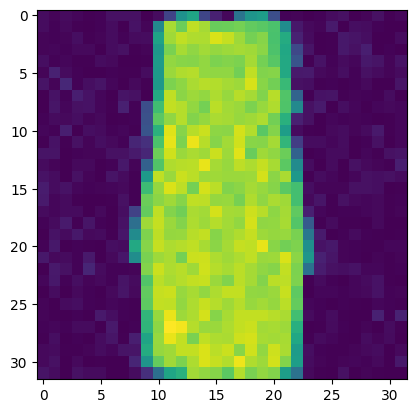

In [237]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [238]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [239]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [240]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [241]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.4443826040129104
distancia energia distribucion base y el ejemplo natural  1.7841780437115382


In [242]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [243]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.572793718214355
distancia energia distribucion base y el ejemplo adversario  2.988274416062498


In [244]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-245-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-245-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

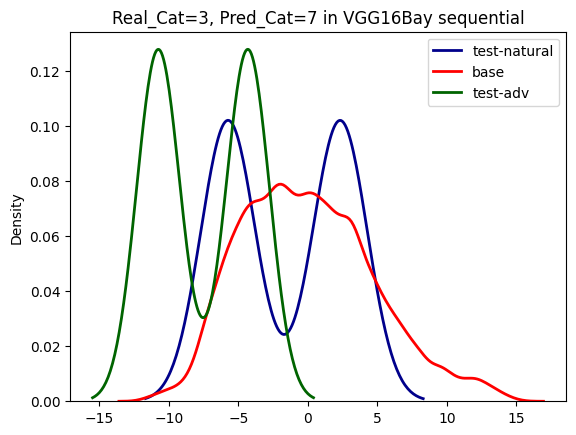

In [245]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [246]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [247]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [248]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [249]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [250]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [251]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [252]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  3


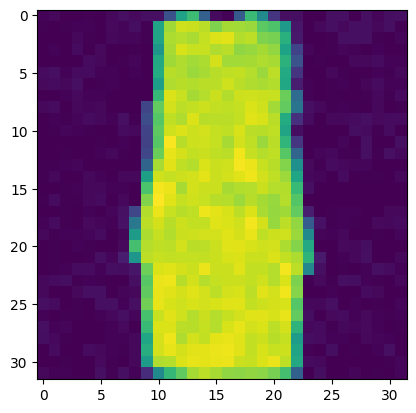

In [253]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [254]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [255]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [256]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [257]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  8.338328047343598
distancia energia distribucion base y el ejemplo natural  3.17292159966857


In [258]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [259]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  14.459986575549026
distancia energia distribucion base y el ejemplo adversario  4.695296524725873


In [260]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-261-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-261-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

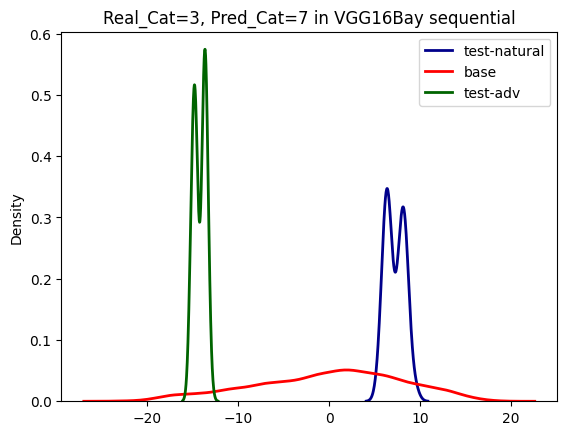

In [261]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [262]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [263]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [264]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 3071.2251 - accuracy: 0.0906


[3071.22509765625, 0.0906040295958519]

In [265]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 57ms/step - loss: 115.6908 - accuracy: 0.2047


[115.6908187866211, 0.20469798147678375]

### vgg_b1R

In [266]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [267]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [268]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [269]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [270]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [271]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [272]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  3


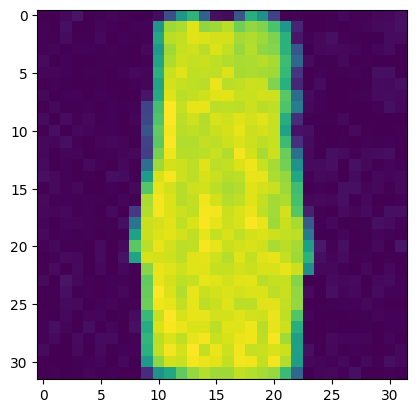

In [273]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [274]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [275]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [276]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [277]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.5815858484221557
distancia energia distribucion base y el ejemplo natural  1.525242141320033


In [278]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [279]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.5772882295090884
distancia energia distribucion base y el ejemplo adversario  1.7479059571285136


In [280]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-281-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-281-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

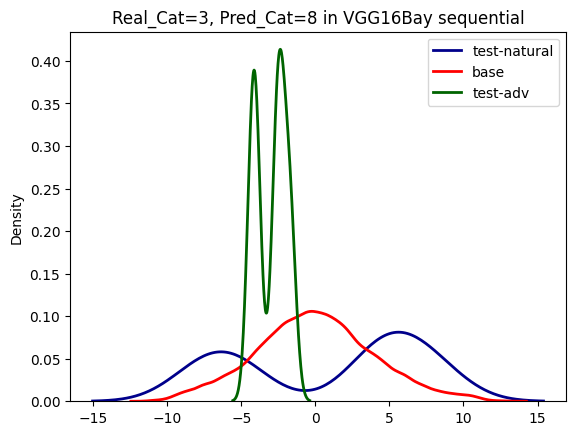

In [281]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [282]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [283]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [284]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [285]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [286]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [287]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [288]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  3


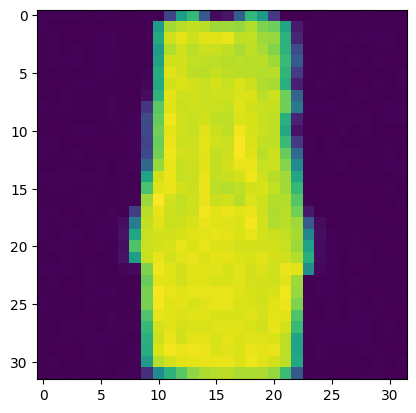

In [289]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [290]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [291]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [292]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [293]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.9282651583656376
distancia energia distribucion base y el ejemplo natural  1.5103229683511863


In [294]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [295]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.912049567795502
distancia energia distribucion base y el ejemplo adversario  1.3703390235931194


In [296]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-297-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-297-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

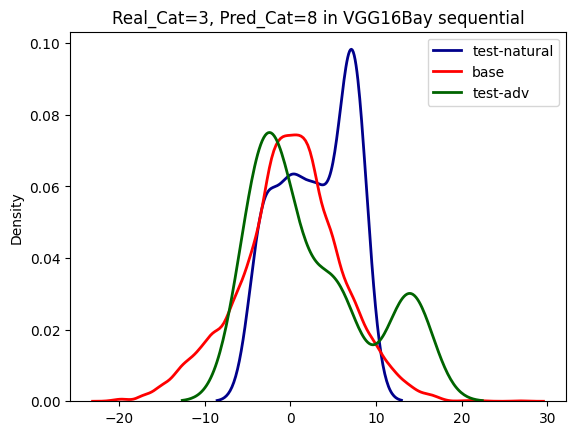

In [297]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [298]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [299]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [300]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 3076.5938 - accuracy: 0.0000e+00


[3076.59375, 0.0]

In [301]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 48ms/step - loss: 123.8658 - accuracy: 0.0000e+00


[123.86577606201172, 0.0]

### vgg_b1R

In [302]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [303]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [304]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [305]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [306]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [307]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [308]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  3


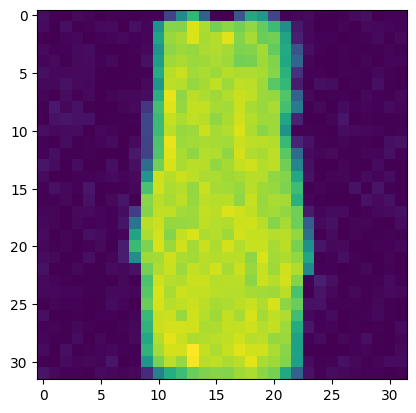

In [309]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [310]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [311]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [312]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [313]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.6921343417053887
distancia energia distribucion base y el ejemplo natural  1.2610249098802746


In [314]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [315]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.104431028979329
distancia energia distribucion base y el ejemplo adversario  2.0609139095300626


In [316]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-317-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-317-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

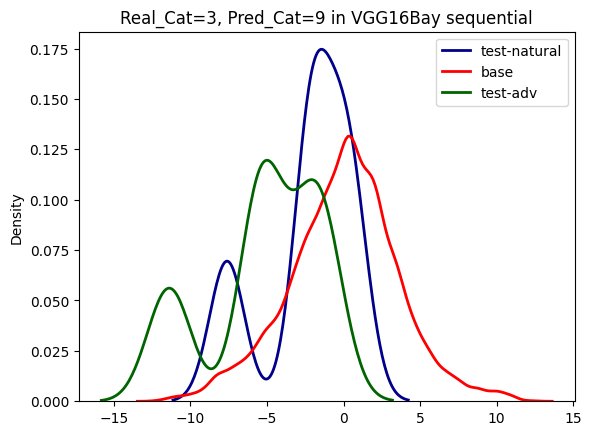

In [317]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [318]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [319]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [320]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [321]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [322]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [323]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [324]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  3


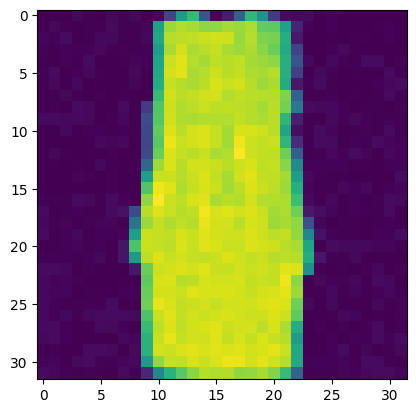

In [325]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [326]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [327]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [328]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [329]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.1697397216754464
distancia energia distribucion base y el ejemplo natural  1.242960182913345


In [330]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [331]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.7693958324489487
distancia energia distribucion base y el ejemplo adversario  1.4384073746724961


In [332]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-333-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-333-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

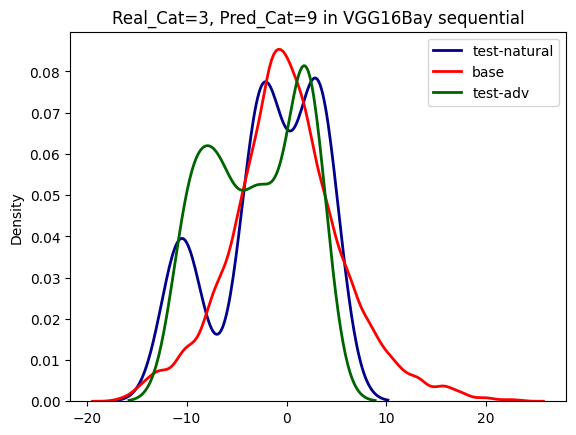

In [333]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

# Lista de Variables para Configuración Primer Epxilon

In [11]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = '001'
Epx_val = 0.01
DS = DS

# Victima 2

## Ataque 0

In [12]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 2
Vic_loc = 25
Cat = 0

In [13]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [14]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 4s 77ms/step - loss: 3072.0193 - accuracy: 0.0297


[3072.019287109375, 0.02967032976448536]

In [15]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 4s 79ms/step - loss: 120.5914 - accuracy: 0.0088


[120.59139251708984, 0.008791209198534489]

### vgg_b1R

In [16]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [17]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [18]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [19]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [20]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [21]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [22]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


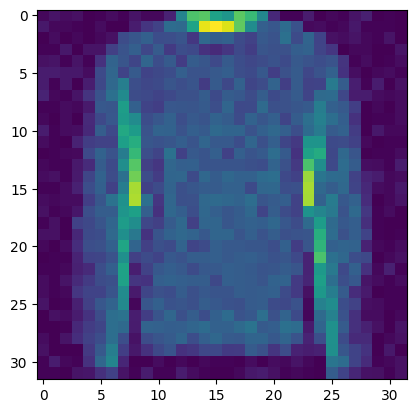

In [23]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [24]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [25]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [26]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [27]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1798931026333976
distancia energia distribucion base y el ejemplo natural  1.1454303862380106


In [28]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [29]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.9289110098896551
distancia energia distribucion base y el ejemplo adversario  0.9684600081552867


In [30]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-31-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-31-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

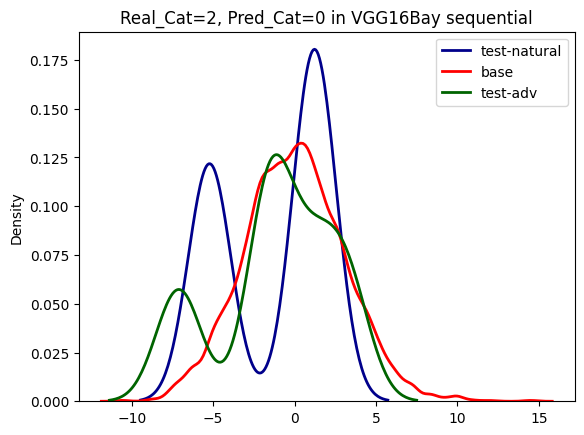

In [31]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [32]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [33]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [34]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [35]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [36]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [37]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [38]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


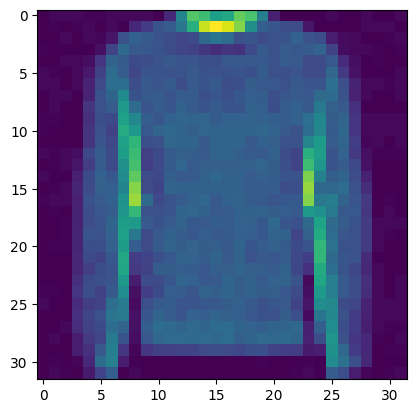

In [39]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [40]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [41]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [42]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [43]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.477010678997191
distancia energia distribucion base y el ejemplo natural  1.5381916591728018


In [44]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [45]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.919046705740969
distancia energia distribucion base y el ejemplo adversario  1.6843133263446888


In [46]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-47-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-47-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

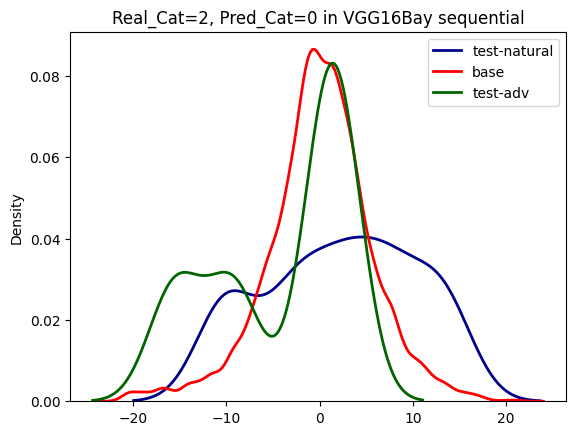

In [47]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [48]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [49]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [50]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 55ms/step - loss: 3070.7141 - accuracy: 0.0428


[3070.714111328125, 0.04284103587269783]

In [51]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 55ms/step - loss: 111.9782 - accuracy: 0.8952


[111.9781723022461, 0.89515221118927]

### vgg_b1R

In [52]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [53]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [54]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [55]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [56]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [57]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [58]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


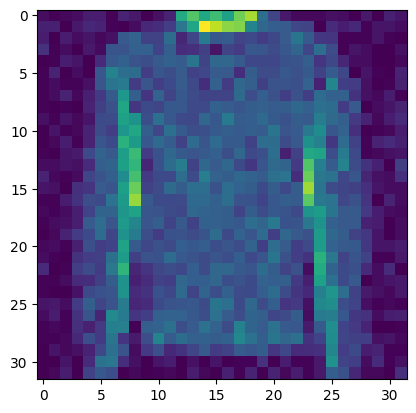

In [59]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [60]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[6]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [61]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [62]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [63]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5528646168574194
distancia energia distribucion base y el ejemplo natural  0.8862638062634635


In [64]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [65]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.763393430590034
distancia energia distribucion base y el ejemplo adversario  0.972794204819499


In [66]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-67-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-67-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

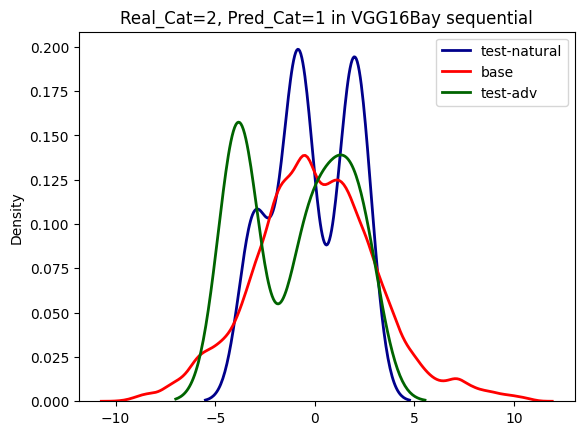

In [67]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [68]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [69]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [70]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [71]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [72]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [73]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [74]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


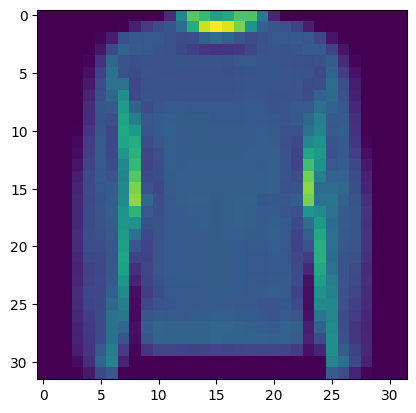

In [75]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [76]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [77]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [78]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [79]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.561875927749483
distancia energia distribucion base y el ejemplo natural  1.5481715699663647


In [80]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [81]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  6.81427495865325
distancia energia distribucion base y el ejemplo adversario  2.2834560433615425


In [82]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-83-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-83-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

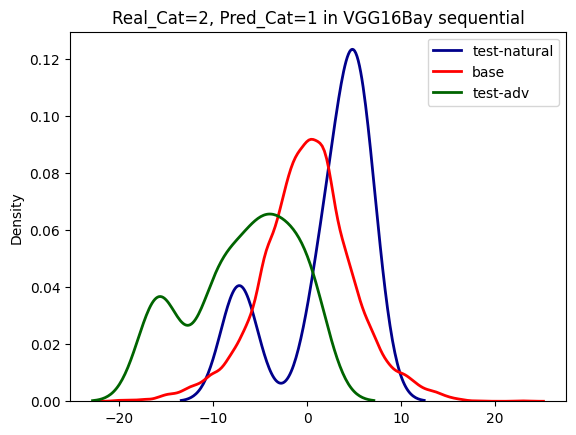

In [83]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [84]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [85]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [86]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 58ms/step - loss: 3070.8201 - accuracy: 0.0791


[3070.820068359375, 0.07906458526849747]

In [87]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 57ms/step - loss: 121.9388 - accuracy: 0.0267


[121.93879699707031, 0.02672605775296688]

### vgg_b1R

In [88]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [89]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [90]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [91]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [92]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [93]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [94]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


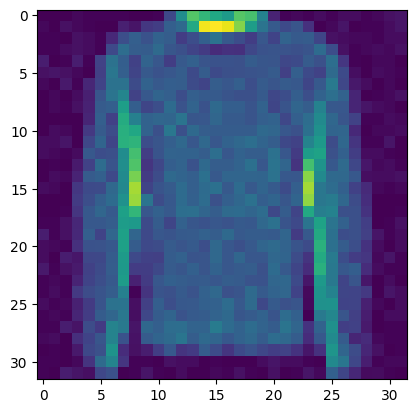

In [95]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [96]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [97]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [98]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [99]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.9884663951405686
distancia energia distribucion base y el ejemplo natural  1.7468744446575115


In [100]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [101]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.2233382732069873
distancia energia distribucion base y el ejemplo adversario  1.8621816435268002


In [102]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-103-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-103-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

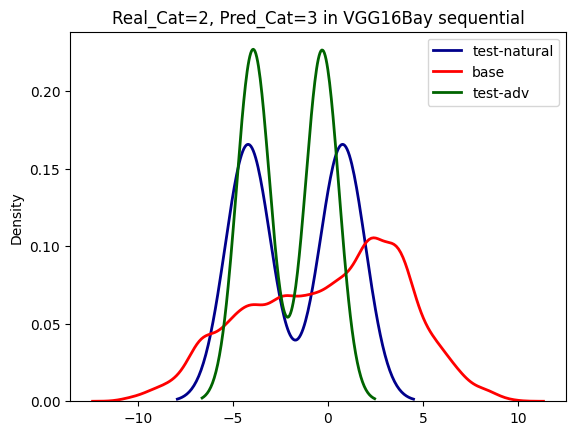

In [103]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [104]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [105]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [106]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [107]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [108]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [109]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [110]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


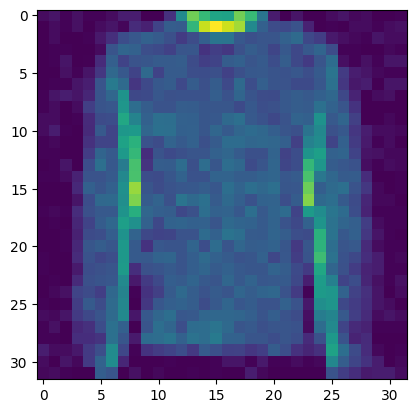

In [111]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [112]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [113]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [114]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [115]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.305059627782814
distancia energia distribucion base y el ejemplo natural  2.51937120506138


In [116]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [117]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  14.176386864762689
distancia energia distribucion base y el ejemplo adversario  4.570411539112977


In [118]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-119-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-119-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

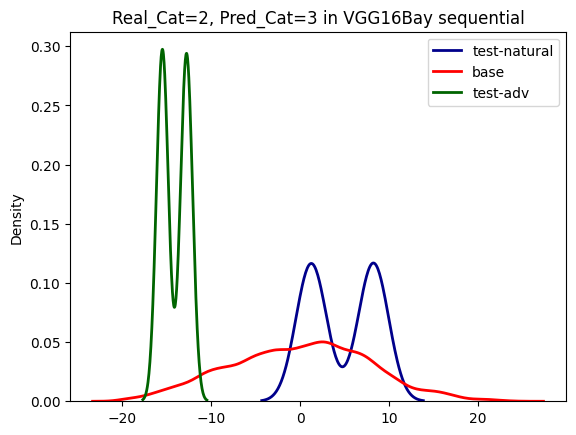

In [119]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [120]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [121]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [122]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 60ms/step - loss: 3072.0818 - accuracy: 0.0471


[3072.081787109375, 0.04708520323038101]

In [123]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 120.7544 - accuracy: 0.0112


[120.75442504882812, 0.011210761964321136]

### vgg_b1R

In [124]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [125]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [126]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [127]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [128]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [129]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [130]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


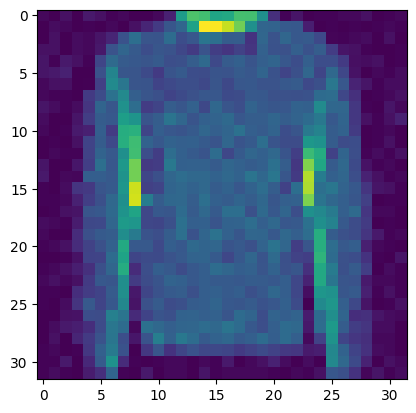

In [131]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [132]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [133]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [134]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [135]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.276236148329698
distancia energia distribucion base y el ejemplo natural  1.1813359410925468


In [136]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [137]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.737309944806612
distancia energia distribucion base y el ejemplo adversario  0.9190811177811067


In [138]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-139-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-139-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

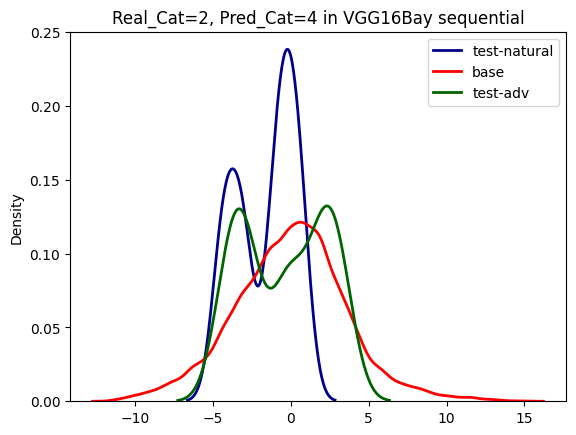

In [139]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [140]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [141]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [142]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [143]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [144]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [145]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [146]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  2


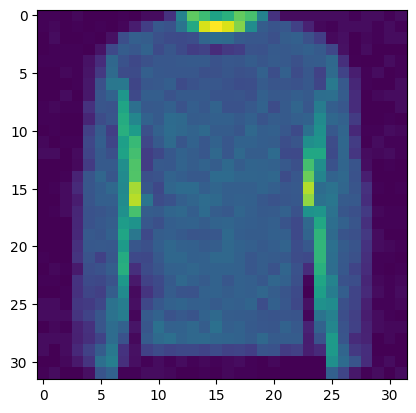

In [147]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [148]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [149]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [150]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [151]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.671166290009946
distancia energia distribucion base y el ejemplo natural  1.1579045614927772


In [152]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [153]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.943120619412636
distancia energia distribucion base y el ejemplo adversario  1.4966606160023634


In [154]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-155-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-155-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

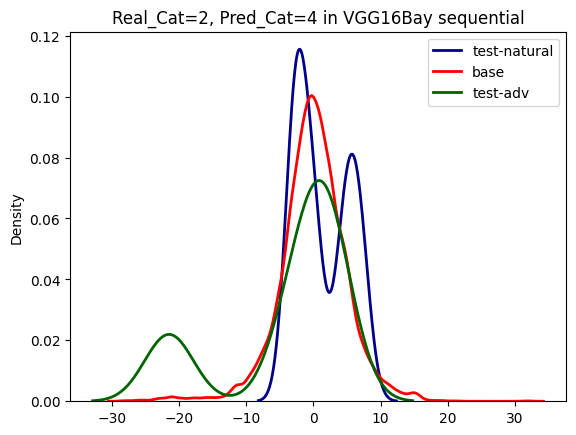

In [155]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [156]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [157]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [158]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 53ms/step - loss: 3072.9688 - accuracy: 0.0597


[3072.96875, 0.059734512120485306]

In [159]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 53ms/step - loss: 119.0976 - accuracy: 0.0918


[119.09756469726562, 0.09181416034698486]

### vgg_b1R

In [160]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [161]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [162]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [163]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [164]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [165]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [166]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


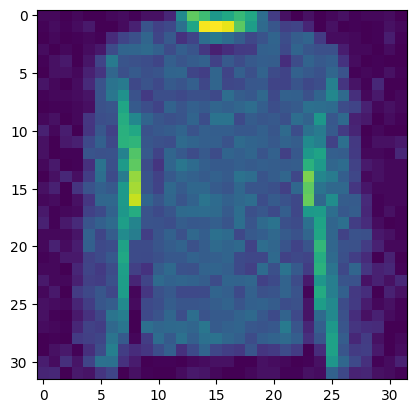

In [167]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [168]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [169]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [170]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [171]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  5.274878978739975
distancia energia distribucion base y el ejemplo natural  2.429233369546867


In [172]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [173]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.4170314118719824
distancia energia distribucion base y el ejemplo adversario  2.2968573725957357


In [174]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-175-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-175-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

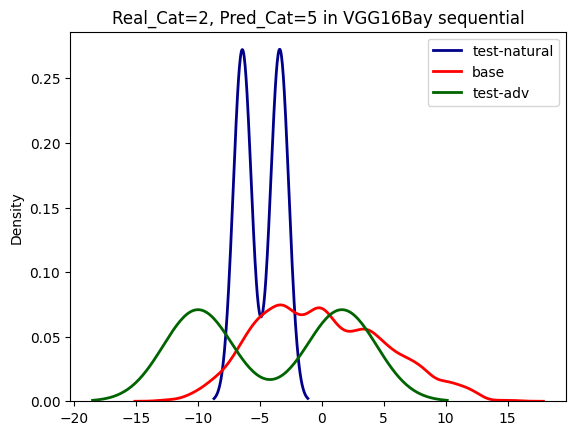

In [175]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [176]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [177]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [178]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [179]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [180]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [181]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [182]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  2


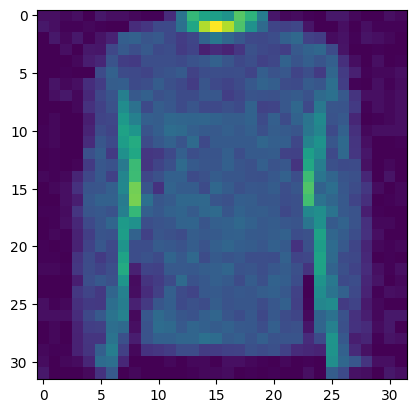

In [183]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [184]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [185]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [186]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [187]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.324089404434133
distancia energia distribucion base y el ejemplo natural  2.4471706512621227


In [188]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [189]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  11.032613891760095
distancia energia distribucion base y el ejemplo adversario  3.662639427037597


In [190]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-191-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-191-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

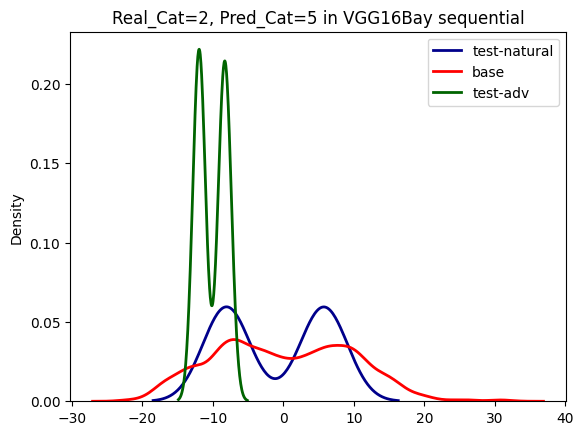

In [191]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [192]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [193]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [194]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 61ms/step - loss: 3070.4727 - accuracy: 0.1257


[3070.47265625, 0.12570782005786896]

In [195]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 62ms/step - loss: 124.2644 - accuracy: 0.0011


[124.26444244384766, 0.0011325028026476502]

### vgg_b1R

In [196]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [197]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [198]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [199]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [200]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [201]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [202]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


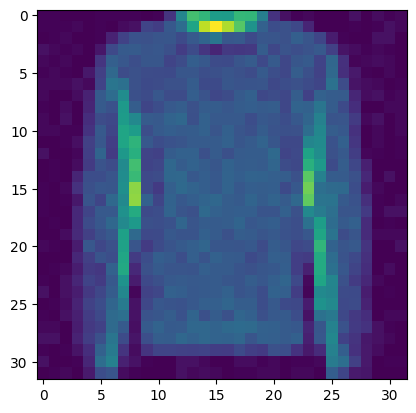

In [203]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [204]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [205]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [206]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [207]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.4880233906477986
distancia energia distribucion base y el ejemplo natural  1.127972408252754


In [208]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [209]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.0653932159369877
distancia energia distribucion base y el ejemplo adversario  1.0715132294041652


In [210]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-211-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-211-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

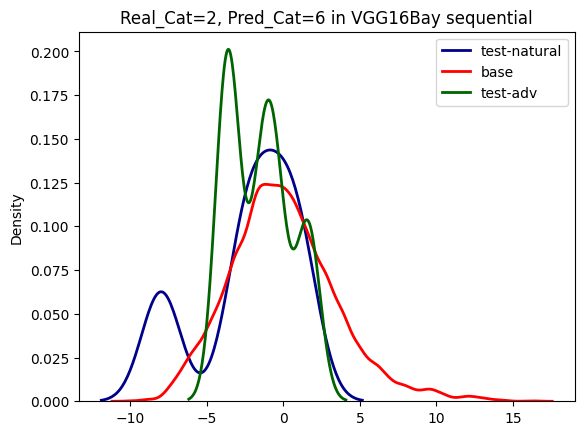

In [211]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [212]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [213]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [214]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [215]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [216]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [217]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [218]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  2


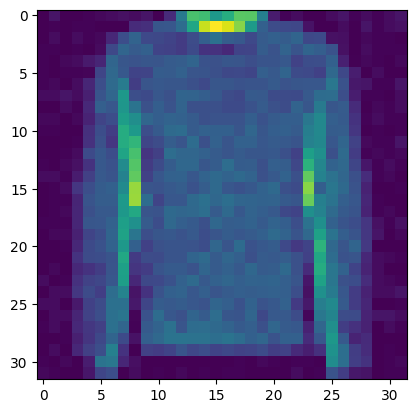

In [219]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [220]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [221]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [222]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [223]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.461476943263441
distancia energia distribucion base y el ejemplo natural  1.5904320136814516


In [224]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [225]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.282491280856369
distancia energia distribucion base y el ejemplo adversario  1.499016725681355


In [226]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-227-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-227-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

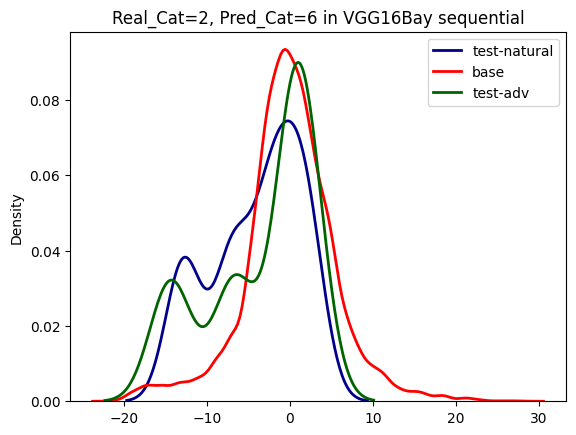

In [227]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [228]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [229]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [230]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 50ms/step - loss: 3072.7300 - accuracy: 0.0197


[3072.72998046875, 0.01971522532403469]

In [231]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 121.8617 - accuracy: 0.0120


[121.86168670654297, 0.012048192322254181]

### vgg_b1R

In [232]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [233]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [234]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [235]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [236]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [237]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [238]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  2


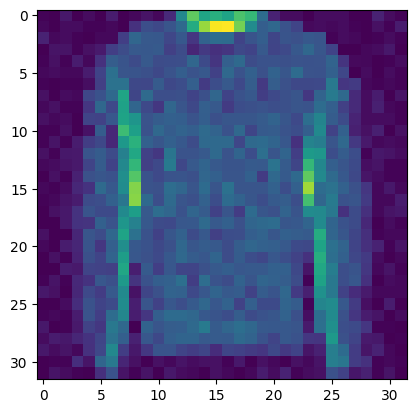

In [239]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [240]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [241]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [242]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [243]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.449435743748792
distancia energia distribucion base y el ejemplo natural  1.7862710009571887


In [244]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [245]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.896032937925837
distancia energia distribucion base y el ejemplo adversario  2.473096997277276


In [246]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-247-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-247-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

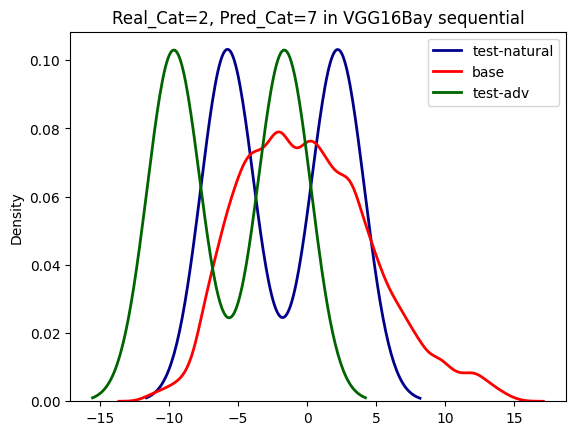

In [247]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [248]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [249]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [250]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [251]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [252]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [253]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [254]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  2


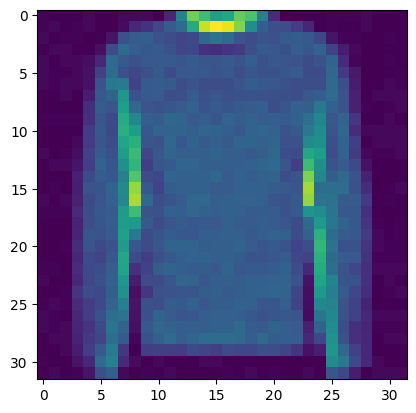

In [255]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [256]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [257]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [258]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [259]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  8.33635073223278
distancia energia distribucion base y el ejemplo natural  3.1916436201889655


In [260]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [261]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  16.580529411103313
distancia energia distribucion base y el ejemplo adversario  4.585656673846116


In [262]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-263-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-263-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

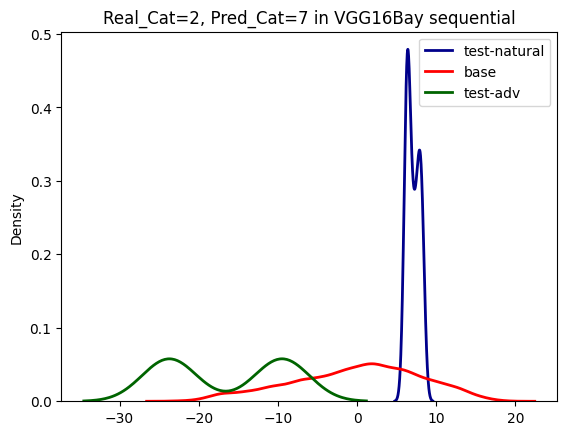

In [263]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [264]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [265]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [266]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 3072.2888 - accuracy: 0.0515


[3072.288818359375, 0.05145413801074028]

In [267]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 115.6888 - accuracy: 0.2181


[115.68880462646484, 0.21812079846858978]

### vgg_b1R

In [268]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [269]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [270]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [271]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [272]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [273]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [274]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


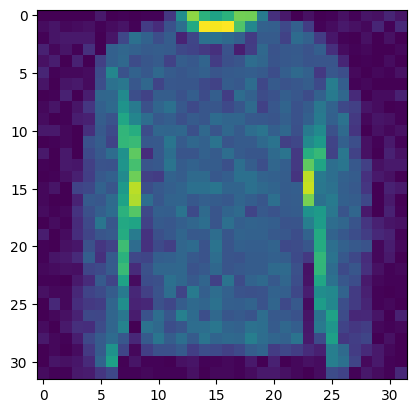

In [275]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [276]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [277]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [278]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [279]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.6622848233301095
distancia energia distribucion base y el ejemplo natural  1.6017497588825664


In [280]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [281]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.6626371717827695
distancia energia distribucion base y el ejemplo adversario  1.25880329049769


In [282]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-283-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-283-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

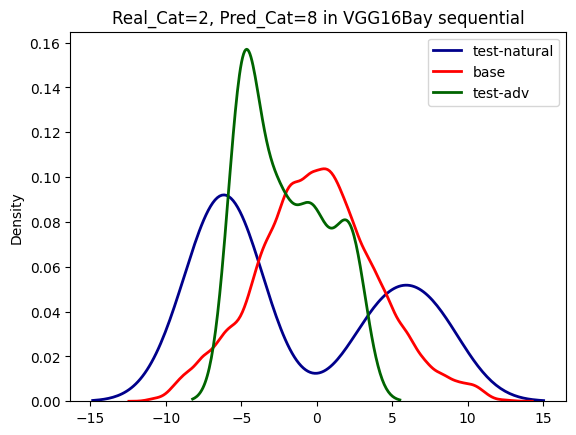

In [283]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [284]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [285]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [286]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [287]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [288]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [289]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [290]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  2


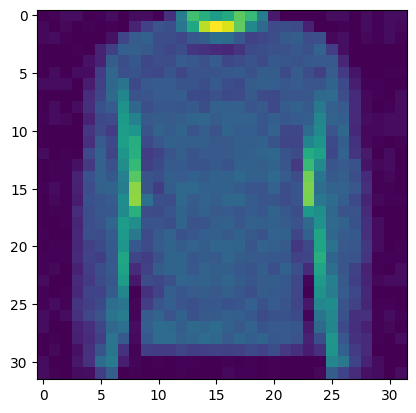

In [291]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [292]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [293]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [294]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [295]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.967324690386205
distancia energia distribucion base y el ejemplo natural  1.5242296802419208


In [296]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [297]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.1773398531399475
distancia energia distribucion base y el ejemplo adversario  1.2833288482120504


In [298]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-299-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-299-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

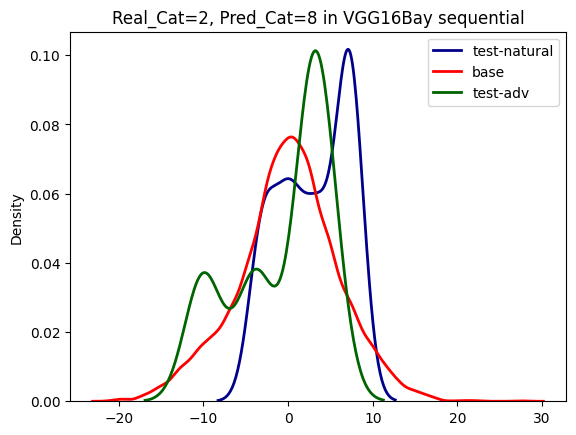

In [299]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [300]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [301]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [302]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 3075.7952 - accuracy: 0.0000e+00


[3075.795166015625, 0.0]

In [303]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 52ms/step - loss: 123.9385 - accuracy: 0.0000e+00


[123.93848419189453, 0.0]

### vgg_b1R

In [304]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [305]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [306]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [307]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [308]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [309]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [310]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


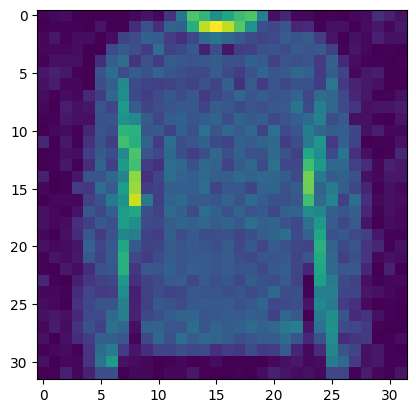

In [311]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [312]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [313]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [314]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [315]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.1470569328815796
distancia energia distribucion base y el ejemplo natural  1.0170107785966476


In [316]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [317]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.877356752246196
distancia energia distribucion base y el ejemplo adversario  2.002943208135604


In [318]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-319-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-319-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

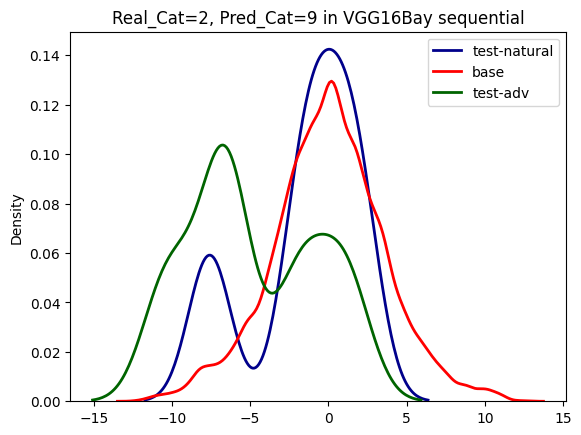

In [319]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [320]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [321]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [322]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [323]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [324]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [325]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [326]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  2


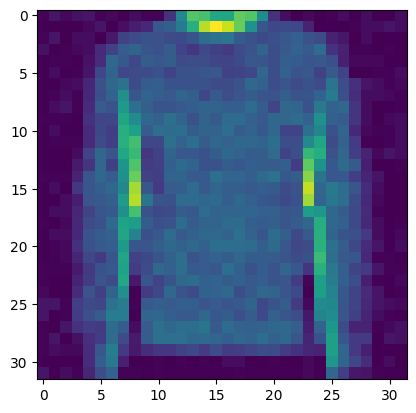

In [327]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [328]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [329]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [330]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [331]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.374717535423657
distancia energia distribucion base y el ejemplo natural  1.3180626071685526


In [332]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [333]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  5.282884961413728
distancia energia distribucion base y el ejemplo adversario  2.0984620962780225


In [334]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-335-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-335-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

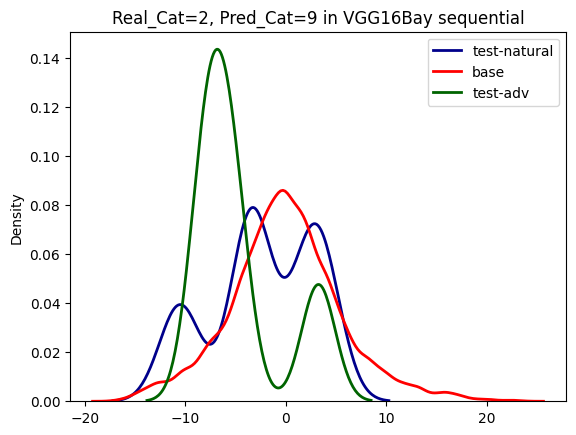

In [335]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 3

## Ataque 0

In [13]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 3
Vic_loc = 36
Cat = 0

In [14]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [15]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 4s 77ms/step - loss: 3072.6707 - accuracy: 0.0099


[3072.670654296875, 0.009890110231935978]

In [16]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 4s 73ms/step - loss: 120.6117 - accuracy: 0.0099


[120.61173248291016, 0.009890110231935978]

### vgg_b1R

In [17]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [18]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [19]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [20]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [21]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [22]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [23]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


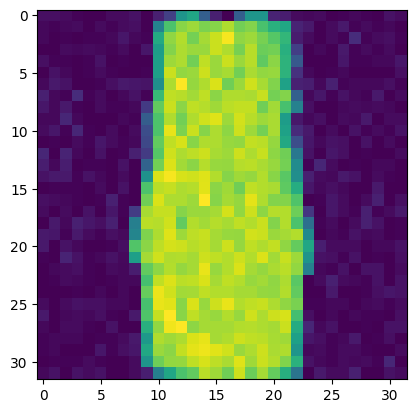

In [24]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [25]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [26]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [27]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [28]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.156404622506425
distancia energia distribucion base y el ejemplo natural  1.1473293080697504


In [29]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [30]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.452470259377256
distancia energia distribucion base y el ejemplo adversario  1.2986069847972286


In [31]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-32-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-32-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

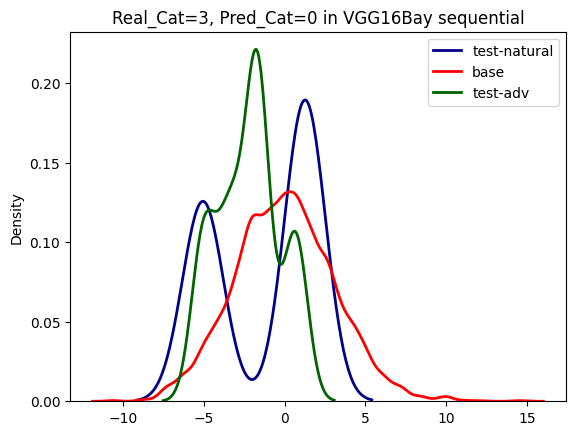

In [32]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [33]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [34]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [35]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [36]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [37]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [38]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [39]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


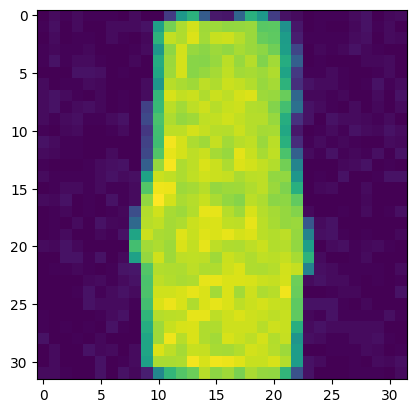

In [40]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [41]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [42]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [43]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [44]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.357562564071152
distancia energia distribucion base y el ejemplo natural  1.4988250114584587


In [45]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [46]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.8658722975357724
distancia energia distribucion base y el ejemplo adversario  1.2230414180892553


In [47]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-48-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-48-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

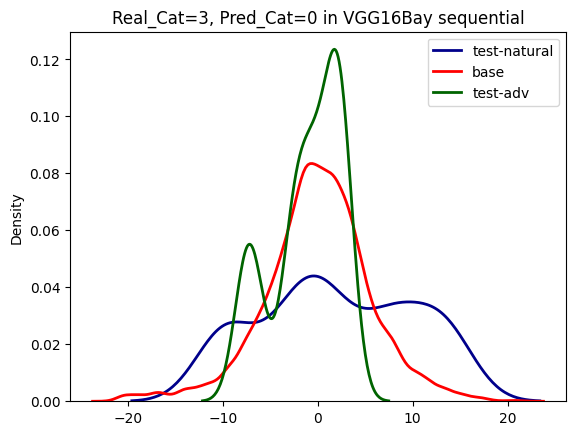

In [48]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [49]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [50]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [51]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 60ms/step - loss: 3070.2119 - accuracy: 0.1375


[3070.2119140625, 0.13754227757453918]

In [52]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 111.9634 - accuracy: 0.9019


[111.9634017944336, 0.9019165635108948]

### vgg_b1R

In [53]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


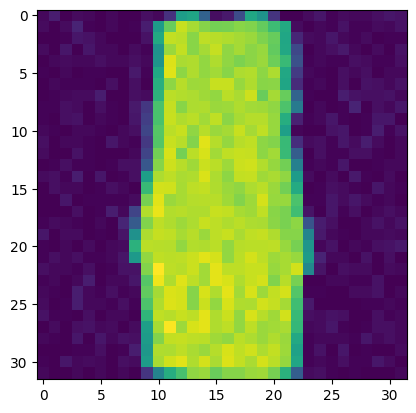

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  1.5362721354454998
distancia energia distribucion base y el ejemplo natural  0.8750187557483114


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.575433390957203
distancia energia distribucion base y el ejemplo adversario  0.8617698943756422


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-68-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-68-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

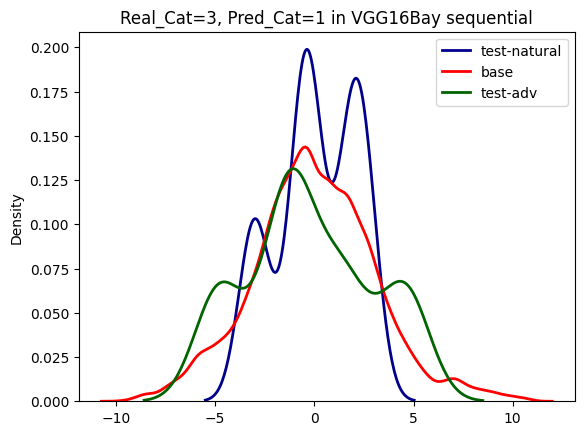

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


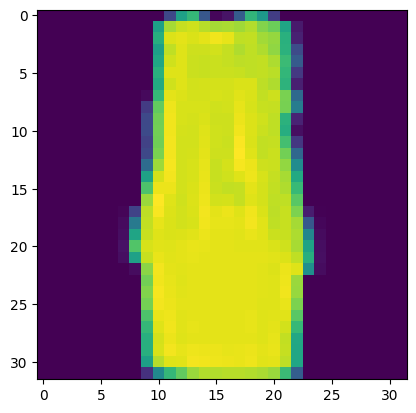

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.4623669545354514
distancia energia distribucion base y el ejemplo natural  1.4939745947854566


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.648860671962896
distancia energia distribucion base y el ejemplo adversario  1.1732855659318184


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-84-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-84-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

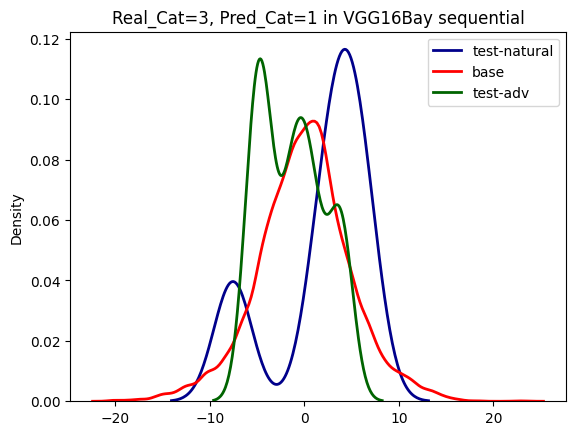

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 58ms/step - loss: 3068.7539 - accuracy: 0.6441


[3068.75390625, 0.6441047787666321]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 55ms/step - loss: 119.6593 - accuracy: 0.0098


[119.65934753417969, 0.009825327433645725]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


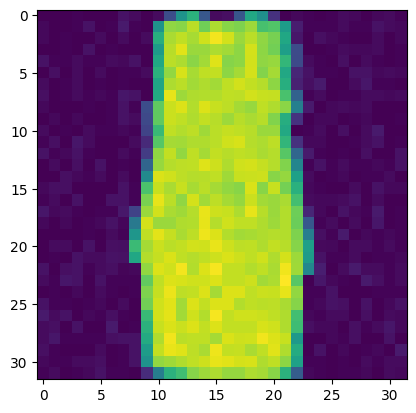

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.086773286098134
distancia energia distribucion base y el ejemplo natural  0.9928997153515711


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.0647299855422636
distancia energia distribucion base y el ejemplo adversario  1.0494191297997053


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-104-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-104-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

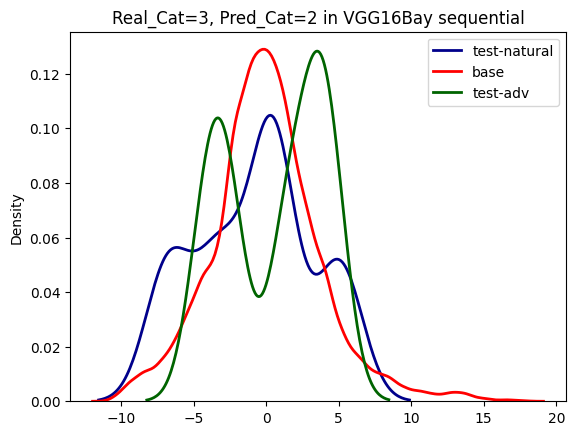

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  3


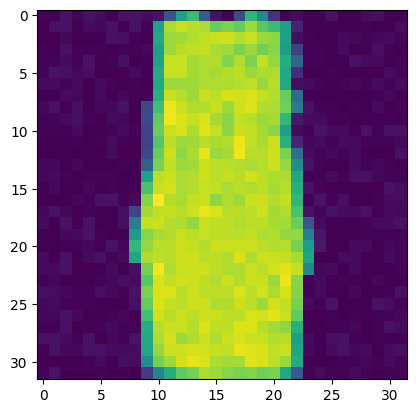

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.826442393684646
distancia energia distribucion base y el ejemplo natural  1.1795785268232388


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9125019501480693
distancia energia distribucion base y el ejemplo adversario  1.2196452437457677


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-120-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-120-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

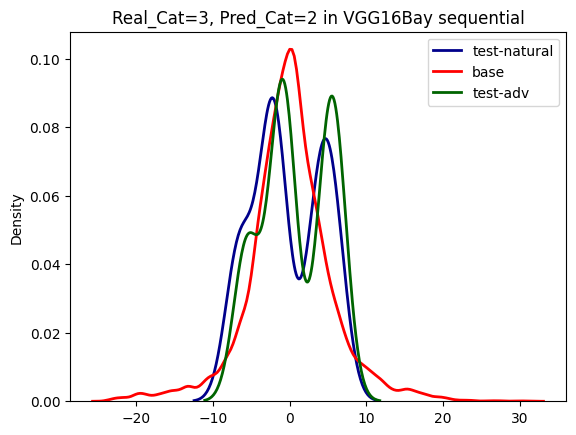

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 59ms/step - loss: 3072.0112 - accuracy: 0.0516


[3072.01123046875, 0.05156950652599335]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 56ms/step - loss: 120.8112 - accuracy: 0.0112


[120.81123352050781, 0.011210761964321136]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  3


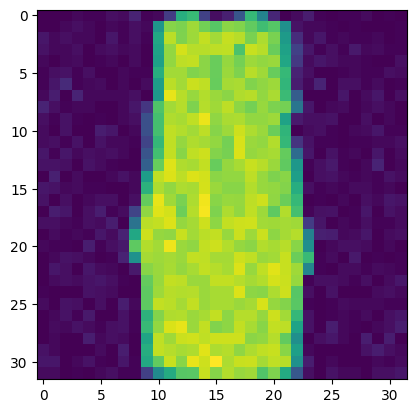

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.3003171149472785
distancia energia distribucion base y el ejemplo natural  1.1898361813494107


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.6171064447427104
distancia energia distribucion base y el ejemplo adversario  1.2172353803944005


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-140-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-140-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

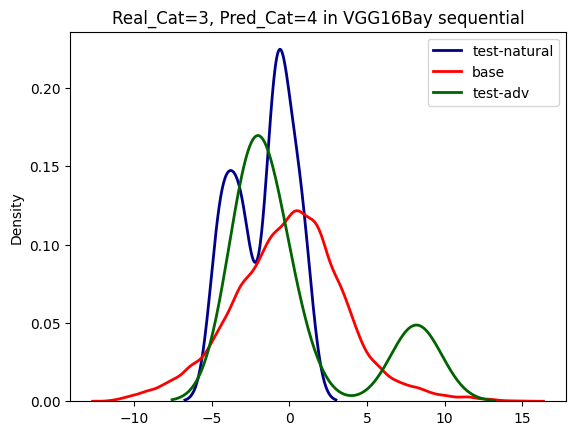

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  3


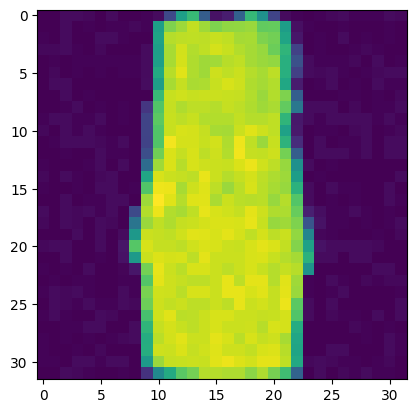

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.014832370984134
distancia energia distribucion base y el ejemplo natural  1.2840951285981177


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  2.9833877734621774
distancia energia distribucion base y el ejemplo adversario  1.2477372887534206


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-156-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-156-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

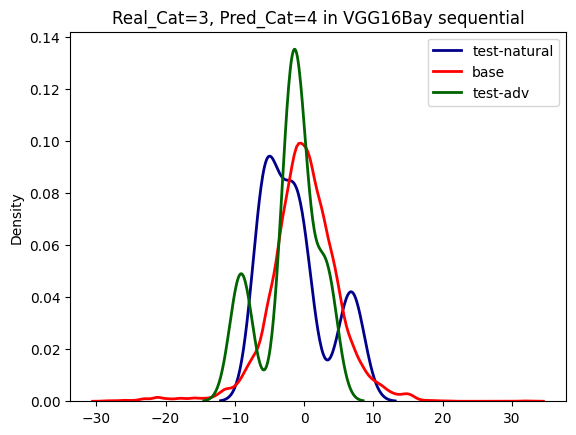

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 49ms/step - loss: 3073.3855 - accuracy: 0.0465


[3073.385498046875, 0.04646017774939537]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 50ms/step - loss: 118.8891 - accuracy: 0.0962


[118.88911437988281, 0.09623894095420837]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  3


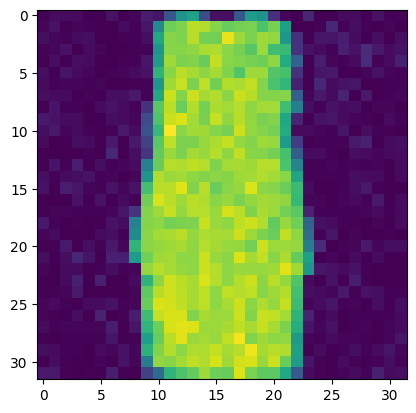

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  5.151101996944941
distancia energia distribucion base y el ejemplo natural  2.380749153549643


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.410101877510599
distancia energia distribucion base y el ejemplo adversario  2.058337157621258


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-176-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-176-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

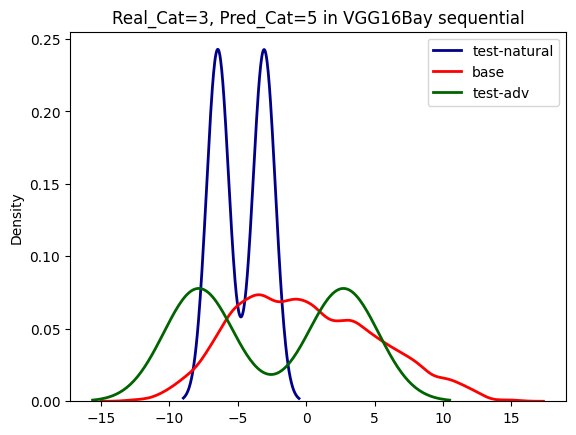

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  3


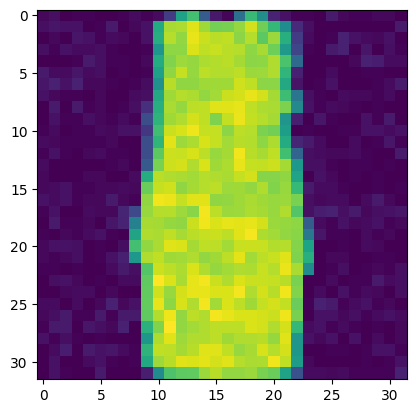

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  6.310055153001993
distancia energia distribucion base y el ejemplo natural  2.4425247926372533


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.3667647191169525
distancia energia distribucion base y el ejemplo adversario  2.6715624955484003


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-192-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-192-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

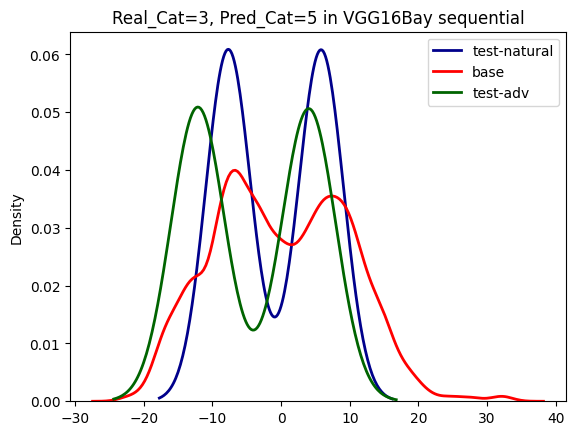

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 55ms/step - loss: 3071.0640 - accuracy: 0.0713


[3071.06396484375, 0.071347676217556]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 54ms/step - loss: 124.2830 - accuracy: 0.0011


[124.282958984375, 0.0011325028026476502]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  3


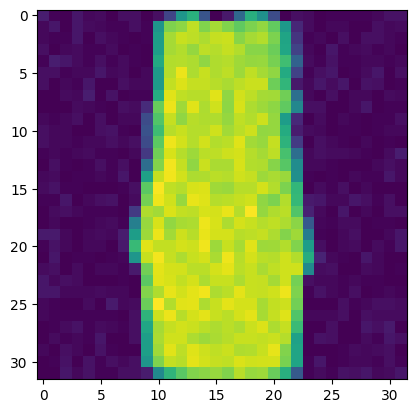

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.46004835701057
distancia energia distribucion base y el ejemplo natural  1.130180036283085


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  1.7646787660366696
distancia energia distribucion base y el ejemplo adversario  0.9257123489267248


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-212-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-212-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

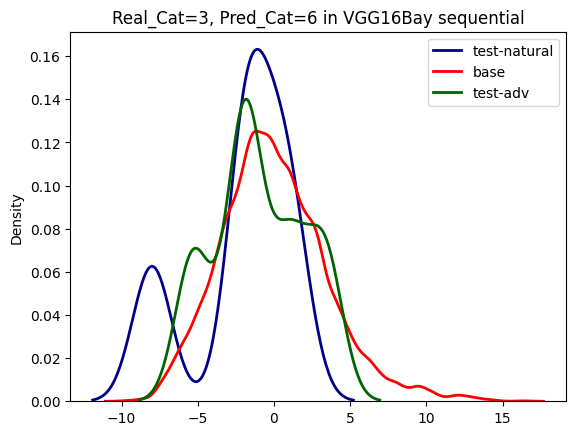

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

el label verdadero es:  3


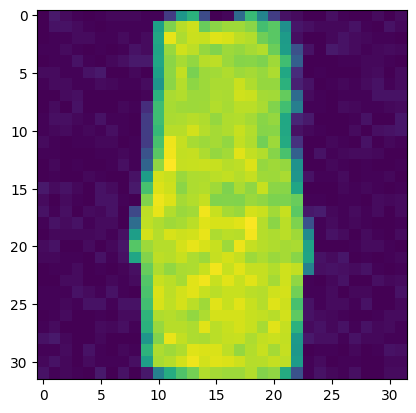

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.251251665388683
distancia energia distribucion base y el ejemplo natural  1.524811992990397


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.46816577967193
distancia energia distribucion base y el ejemplo adversario  1.5143658401414402


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-228-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-228-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

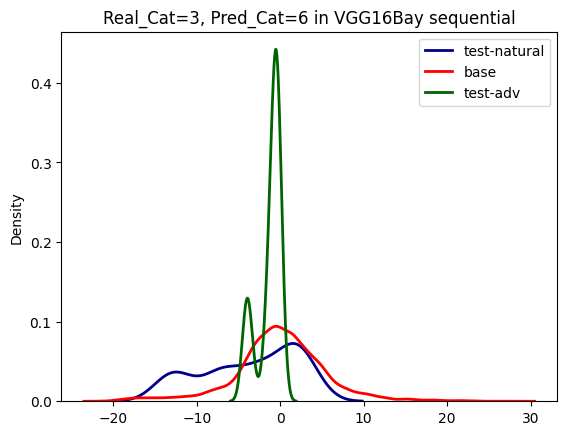

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 3073.3311 - accuracy: 0.0099


[3073.3310546875, 0.009857612662017345]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 49ms/step - loss: 121.7199 - accuracy: 0.0153


[121.71989440917969, 0.015334063209593296]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  3


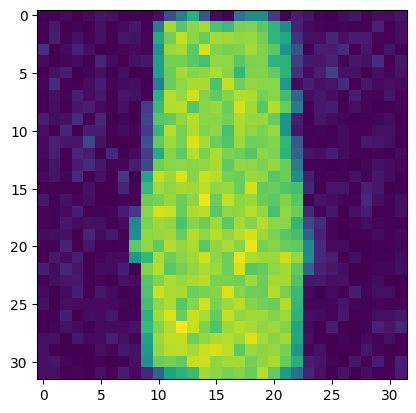

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[9]
[7]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.4315232684869486
distancia energia distribucion base y el ejemplo natural  1.7792617664372614


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  7.227436742033103
distancia energia distribucion base y el ejemplo adversario  2.9061799766361047


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-248-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-248-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

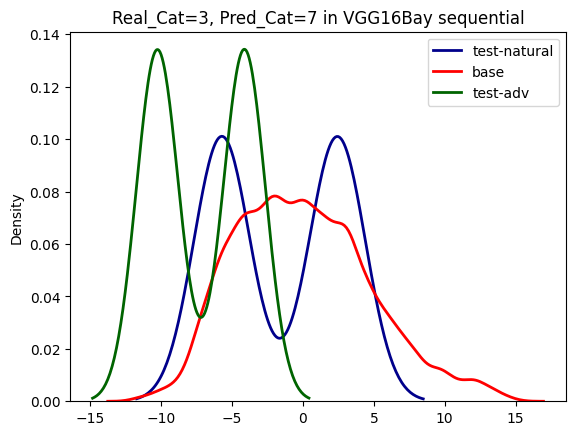

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=2, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  3


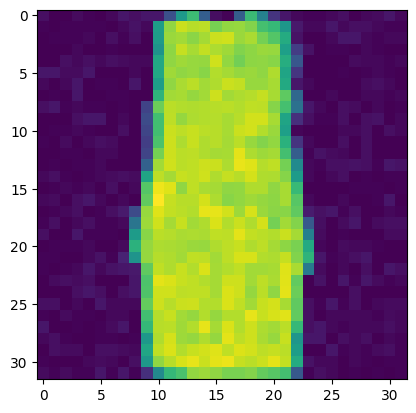

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  8.4226139815285
distancia energia distribucion base y el ejemplo natural  3.1946789630118264


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  14.149048445509994
distancia energia distribucion base y el ejemplo adversario  4.6046234126343455


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-264-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-264-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

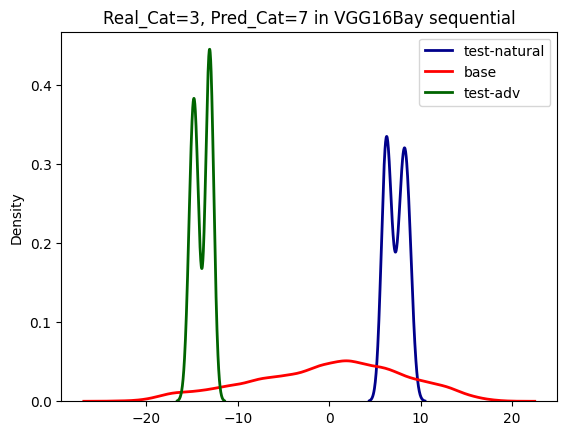

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

7/7 [==============================] - 1s 58ms/step - loss: 3071.9412 - accuracy: 0.0694


[3071.941162109375, 0.06935123354196548]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

7/7 [==============================] - 1s 57ms/step - loss: 115.6965 - accuracy: 0.2136


[115.69652557373047, 0.2136465311050415]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  3


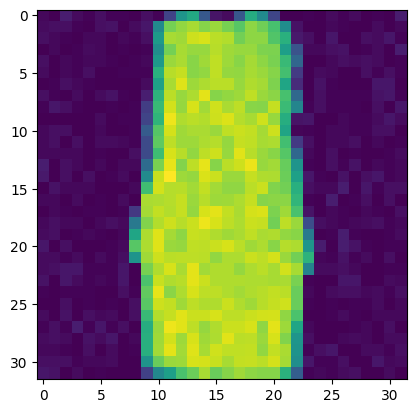

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.588671757278945
distancia energia distribucion base y el ejemplo natural  1.6019873224071413


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  3.18836264242779
distancia energia distribucion base y el ejemplo adversario  1.4886506336325322


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-284-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-284-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

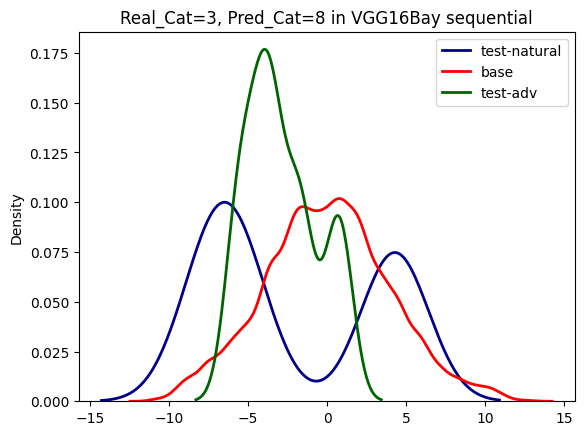

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  3


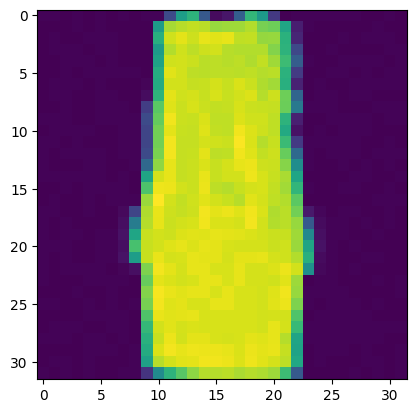

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  4.830509569697283
distancia energia distribucion base y el ejemplo natural  1.8701356718772655


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.1667932513946075
distancia energia distribucion base y el ejemplo adversario  1.4525944468418306


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-300-e33562d77828>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-300-e33562d77828>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

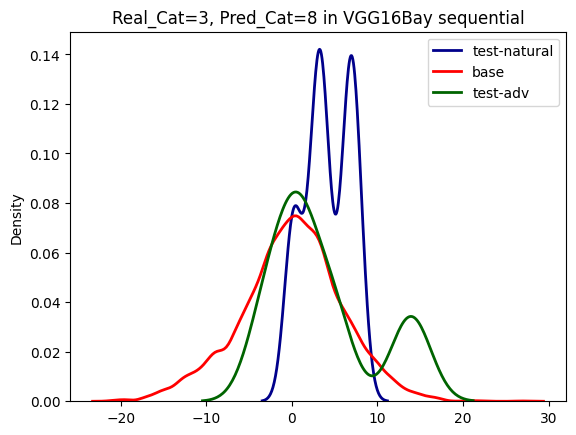

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
BATCH_SIZE = 128
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
clas=Cat

## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

def prepro_db(train_data, train_ = True):
  l = len(train_data)
  train_data = train_data.filter(lambda image, label: label == clas)
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(l)
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

def prepro_dbadv(train_data, train_ = True):
  train_data = train_data.map(img_gen)
  if train_ :
    train_data = train_data.shuffle(len(train_data))
  train_data = train_data.batch(BATCH_SIZE)
  return train_data

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test, False)
test_ds_testadv = prepro_dbadv(test_ds_testadv, False)

In [ ]:
vgg_b1r.evaluate(train_ds_tf)

8/8 [==============================] - 1s 53ms/step - loss: 3076.8694 - accuracy: 0.0000e+00


[3076.869384765625, 0.0]

In [ ]:
vgg_btr.evaluate(train_ds_tf)

8/8 [==============================] - 1s 51ms/step - loss: 123.7228 - accuracy: 0.0000e+00


[123.72277069091797, 0.0]

### vgg_b1R

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_b1r,input_shape=(32,32,1))

0 sequential
1 flatten
2 dense_reparameterization
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  3


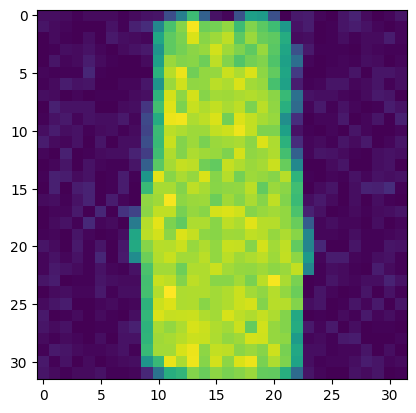

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['dense_reparameterization'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_b1r(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[1]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  2.144104108865939
distancia energia distribucion base y el ejemplo natural  1.0140988892670681


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  4.411518798022001
distancia energia distribucion base y el ejemplo adversario  1.7806504332699455


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-320-6a00c786a8a8>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-320-6a00c786a8a8>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

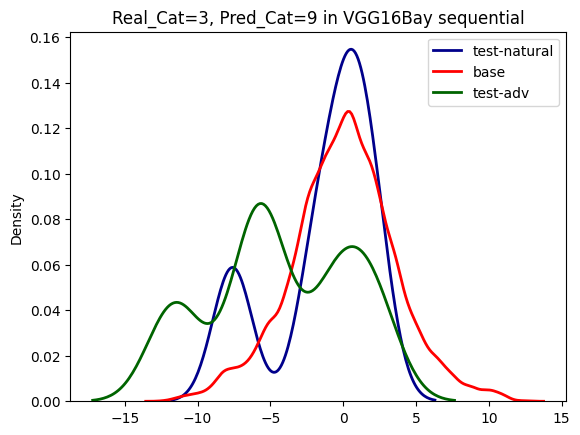

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1Re',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### vgg_btR

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_btr,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 dense
3 one_hot_categorical_1


In [ ]:
transformer = IncrementalPCA(n_components=5, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist['sequential_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  3


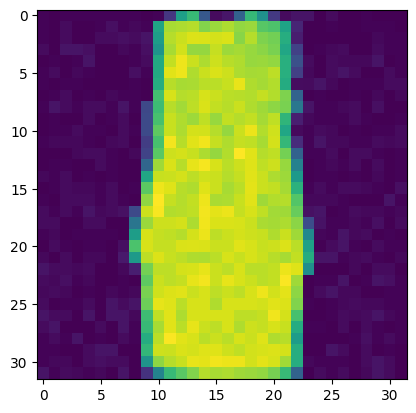

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_btr(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist['sequential_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  3.3776753335081513
distancia energia distribucion base y el ejemplo natural  1.314089041813484


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'BtRe',Cap,Att,Epx,DS,Cat,Vic,'B1')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)